In [1]:
!pip install tensorflow

In [2]:
import json
import os
import fnmatch
import pandas as pd
import seaborn
import numpy as np

import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


# Unzip NASLib/run/results/zc_ensembles.zip, NASLib/run/results/only_zc.zip, and NASLib/run/results/only_adjacency.zip before running the code

In [3]:
BENCHMARKS = {
#     'nasbench101': ['cifar10'],
    'nasbench201': ['cifar10', 'cifar100', 'ImageNet16-120'],
    'nasbench301': ['cifar10'],
    'transbench101_micro': ['jigsaw', 'class_scene', 'class_object', 'autoencoder', 'normal', 'room_layout', 'segmentsemantic'],
    'transbench101_macro': ['jigsaw', 'class_scene', 'class_object', 'autoencoder', 'normal', 'room_layout', 'segmentsemantic']
}

LABELS = {
    'nasbench101': 'NB101',
    'nasbench201': 'NB201',
    'nasbench301': 'NB301',
    'transbench101_micro': 'TNB101_MICRO',
    'transbench101_macro': 'TNB101_MACRO',
    'cifar10': 'CF10',
    'cifar100': 'CF100',
    'ImageNet16-120': 'IMGNT',
    'jigsaw': 'JIGSAW',
    'class_scene': 'SCENE',
    'class_object': 'OBJECT',
    'autoencoder': 'AUTOENC',
    'normal': 'NORMAL',
    'room_layout': 'ROOM',
    'segmentsemantic': 'SEGMENT',
}

START_SEED = 9000
N_SEEDS = 10

def find_files(src='../run/results/only_zc', fname='*events.out.tfevents.*'):
    matches = []
    for root, dirnames, filenames in os.walk(src):
        for filename in fnmatch.filter(filenames, fname):
            matches.append(os.path.join(root, filename))

    return matches

def read_file(event_file, tag):
    vals = []
    for e in tf.train.summary_iterator(event_file):
        for v in e.summary.value:
            if v.tag == tag:
                vals.append(v.simple_value)
    return vals

In [4]:
all_files = find_files()

In [5]:
all_files[0]

'../run/results/only_zc/transbench101_micro/jigsaw/zc/9009/fisher-flops-grad_norm-grasp-jacov-l2_norm-nwot-params-plain-snip/events.out.tfevents.1652922773.kisexe15.990166.0'

In [6]:
def get_scores_as_list_of_dict(files):
    data = []

    for file in files:
        components = file.split('/')
        zc_names, seed, dataset, search_space = components[-2], components[-3], components[-5], components[-6]

        val_accuracies = read_file(file, "Validation accuracy (top 1)")
        train_accuracies = read_file(file, "Train accuracy (top 1)")
        
        if len(val_accuracies) == 0 or len(train_accuracies) == 0:
            continue
        
        record = {
            'search_space': search_space,
            'dataset': dataset,
            'seed': seed,
            'zc_names': zc_names,
            'val_accs': val_accuracies,
            'train_accs': train_accuracies,
        }

        data.append(record)

    return data

def make_df(files):
    data = get_scores_as_list_of_dict(files)
    df = pd.DataFrame(data)
    return df

def clean_df(df):
    bad_indices = []

    for idx, val_acc in enumerate(df['val_accs']):
        if len(val_acc) != 200:
            bad_indices.append(idx)

    df = df.drop(index=bad_indices)
    return df

def get_val_train_accs(df, search_space, dataset):
    df_ = df[(df['search_space'] == search_space) & (df['dataset'] == dataset)]
    
    seed_val_accs = []
    seed_train_accs = []

    for seed in range(START_SEED, START_SEED + N_SEEDS):
        try:
            vals = df_[df_['seed'] == str(seed)]['val_accs'].item()
            train_accs = df_[df_['seed'] == str(seed)]['train_accs'].item()
            seed_val_accs.append(vals)
            seed_train_accs.append(train_accs)
        except:
            print(df_[df_['seed'] == str(seed)]['val_accs'])
    
    return np.array(seed_val_accs), np.array(seed_train_accs)

def plot(x, title, xlabel, ylabel, figsize=(18, 12)):
    
    x_mean = np.mean(x, axis=0)
    x_std = np.std(x, axis=0)
    
    plt.figure(figsize=figsize, dpi=200)
    plt.title(title, fontsize=20)
    plt.plot(x_mean)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)

    plt.fill_between(range(len(x_mean)), x_mean+x_std, x_mean-x_std, alpha=0.6)


def plot_multiple(x_only_zc, x_only_adj, x_zc, title, xlabel, ylabel, figsize=(18, 12)):
    plt.figure(figsize=figsize, dpi=200)
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)

    titles = ('ONLY_ZC', 'ONLY_ADJ', 'BOTH')
    
    for idx, x in enumerate((x_only_zc, x_only_adj, x_zc)):
        x_mean = np.mean(x, axis=0)
        x_std = np.std(x, axis=0)
        plt.plot(x_mean, label=titles[idx])
        plt.fill_between(range(len(x_mean)), x_mean+x_std, x_mean-x_std, alpha=0.4)

    plt.legend()

def plot_for_search_space(df, search_space):
    for dataset in BENCHMARKS[search_space]:
        val_accs, train_accs = get_val_train_accs(df, search_space, dataset)
        plot(val_accs, f'{LABELS[search_space]} {LABELS[dataset]}', 'Epochs', 'Validation Accuracy (Top 1)')

def plot_search_space(search_space, only_zc_df, only_adj_df, zc_df):    
    for dataset in BENCHMARKS[search_space]:
        only_zc_vals, _ = get_val_train_accs(only_zc_df, search_space, dataset)
        only_adj_vals, _ = get_val_train_accs(only_adj_df, search_space, dataset)
        zc_vals, _ = get_val_train_accs(zc_df, search_space, dataset)

        plot_multiple(only_zc_vals, only_adj_vals, zc_vals, f'{LABELS[search_space]} {LABELS[dataset]}', 'Epochs', 'Validation Accuracy (Top 1)' )


In [7]:
# df = make_df(all_files)
# plot_for_search_space(df, 'transbench101_macro')
# plot_for_search_space(df, 'nasbench301')
# plot_for_search_space(df, 'nasbench201')

In [8]:
only_zc_files = find_files(src='../run/results/only_zc')
only_adj_files = find_files(src='../run/results/only_adjacency')
zc_files = find_files(src='../run/results/zc_ensemble')

only_zc_df, only_adj_df, zc_df = clean_df(make_df(only_zc_files)), clean_df(make_df(only_adj_files)), clean_df(make_df(zc_files))

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


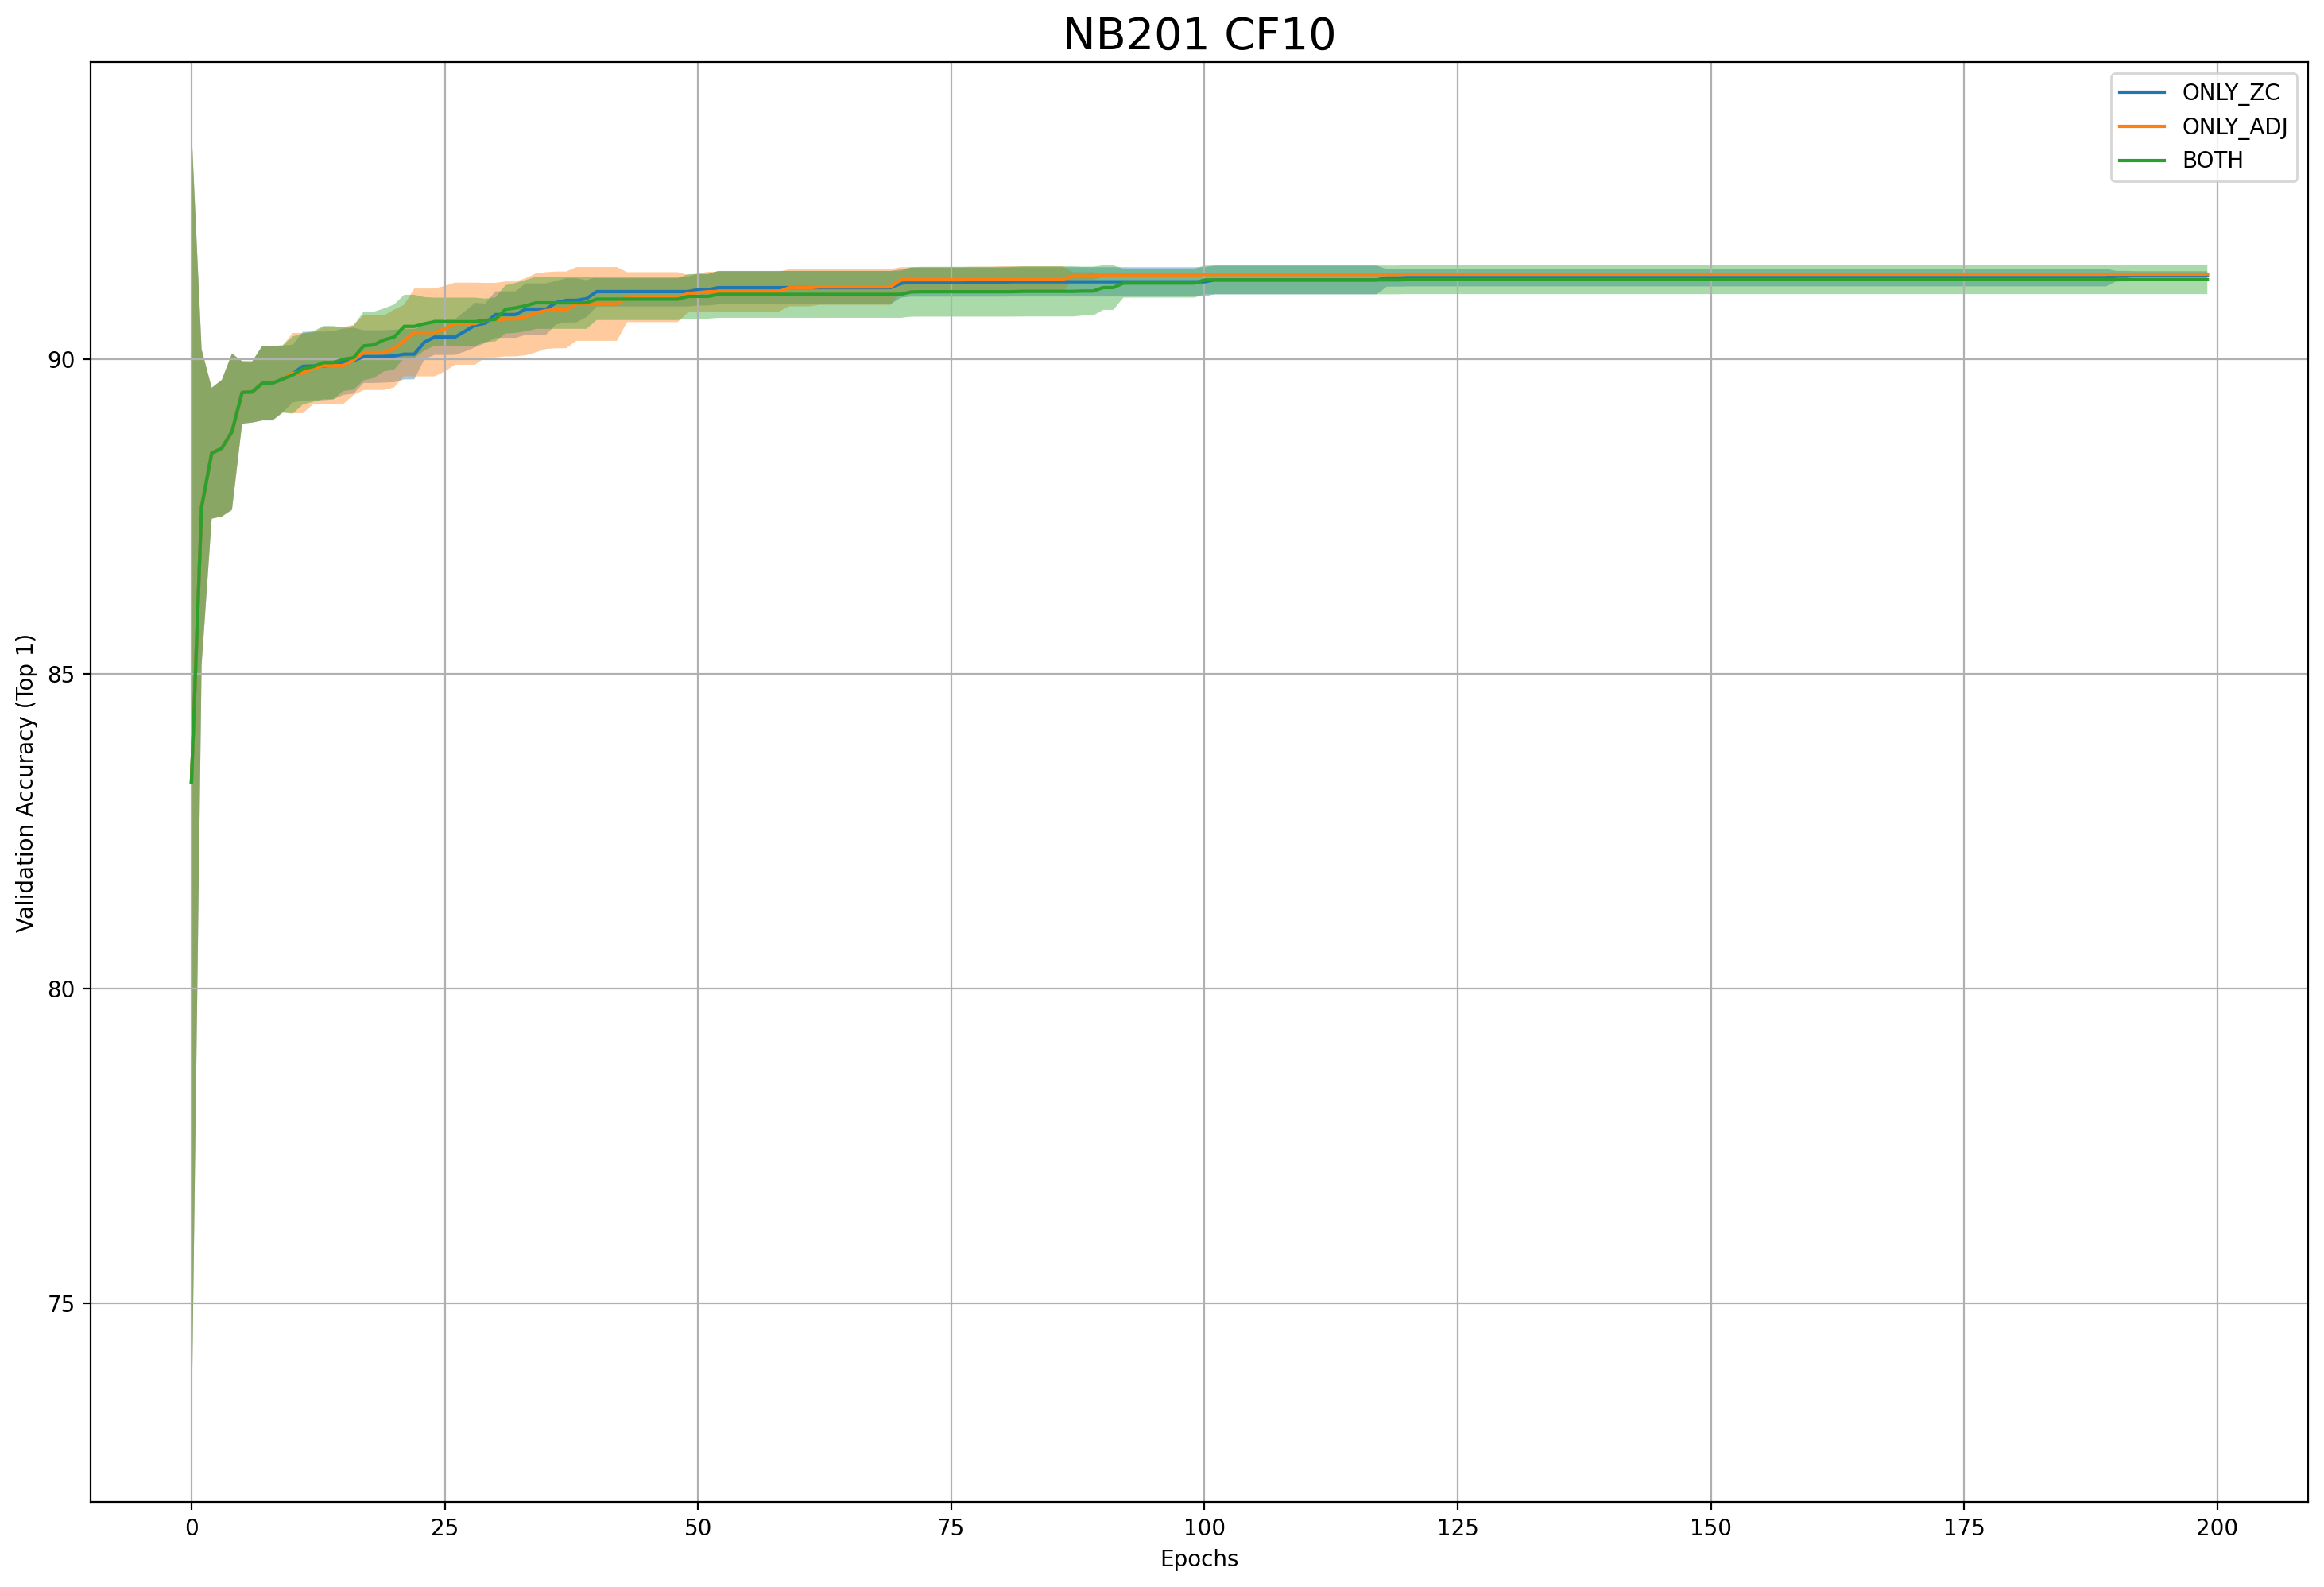

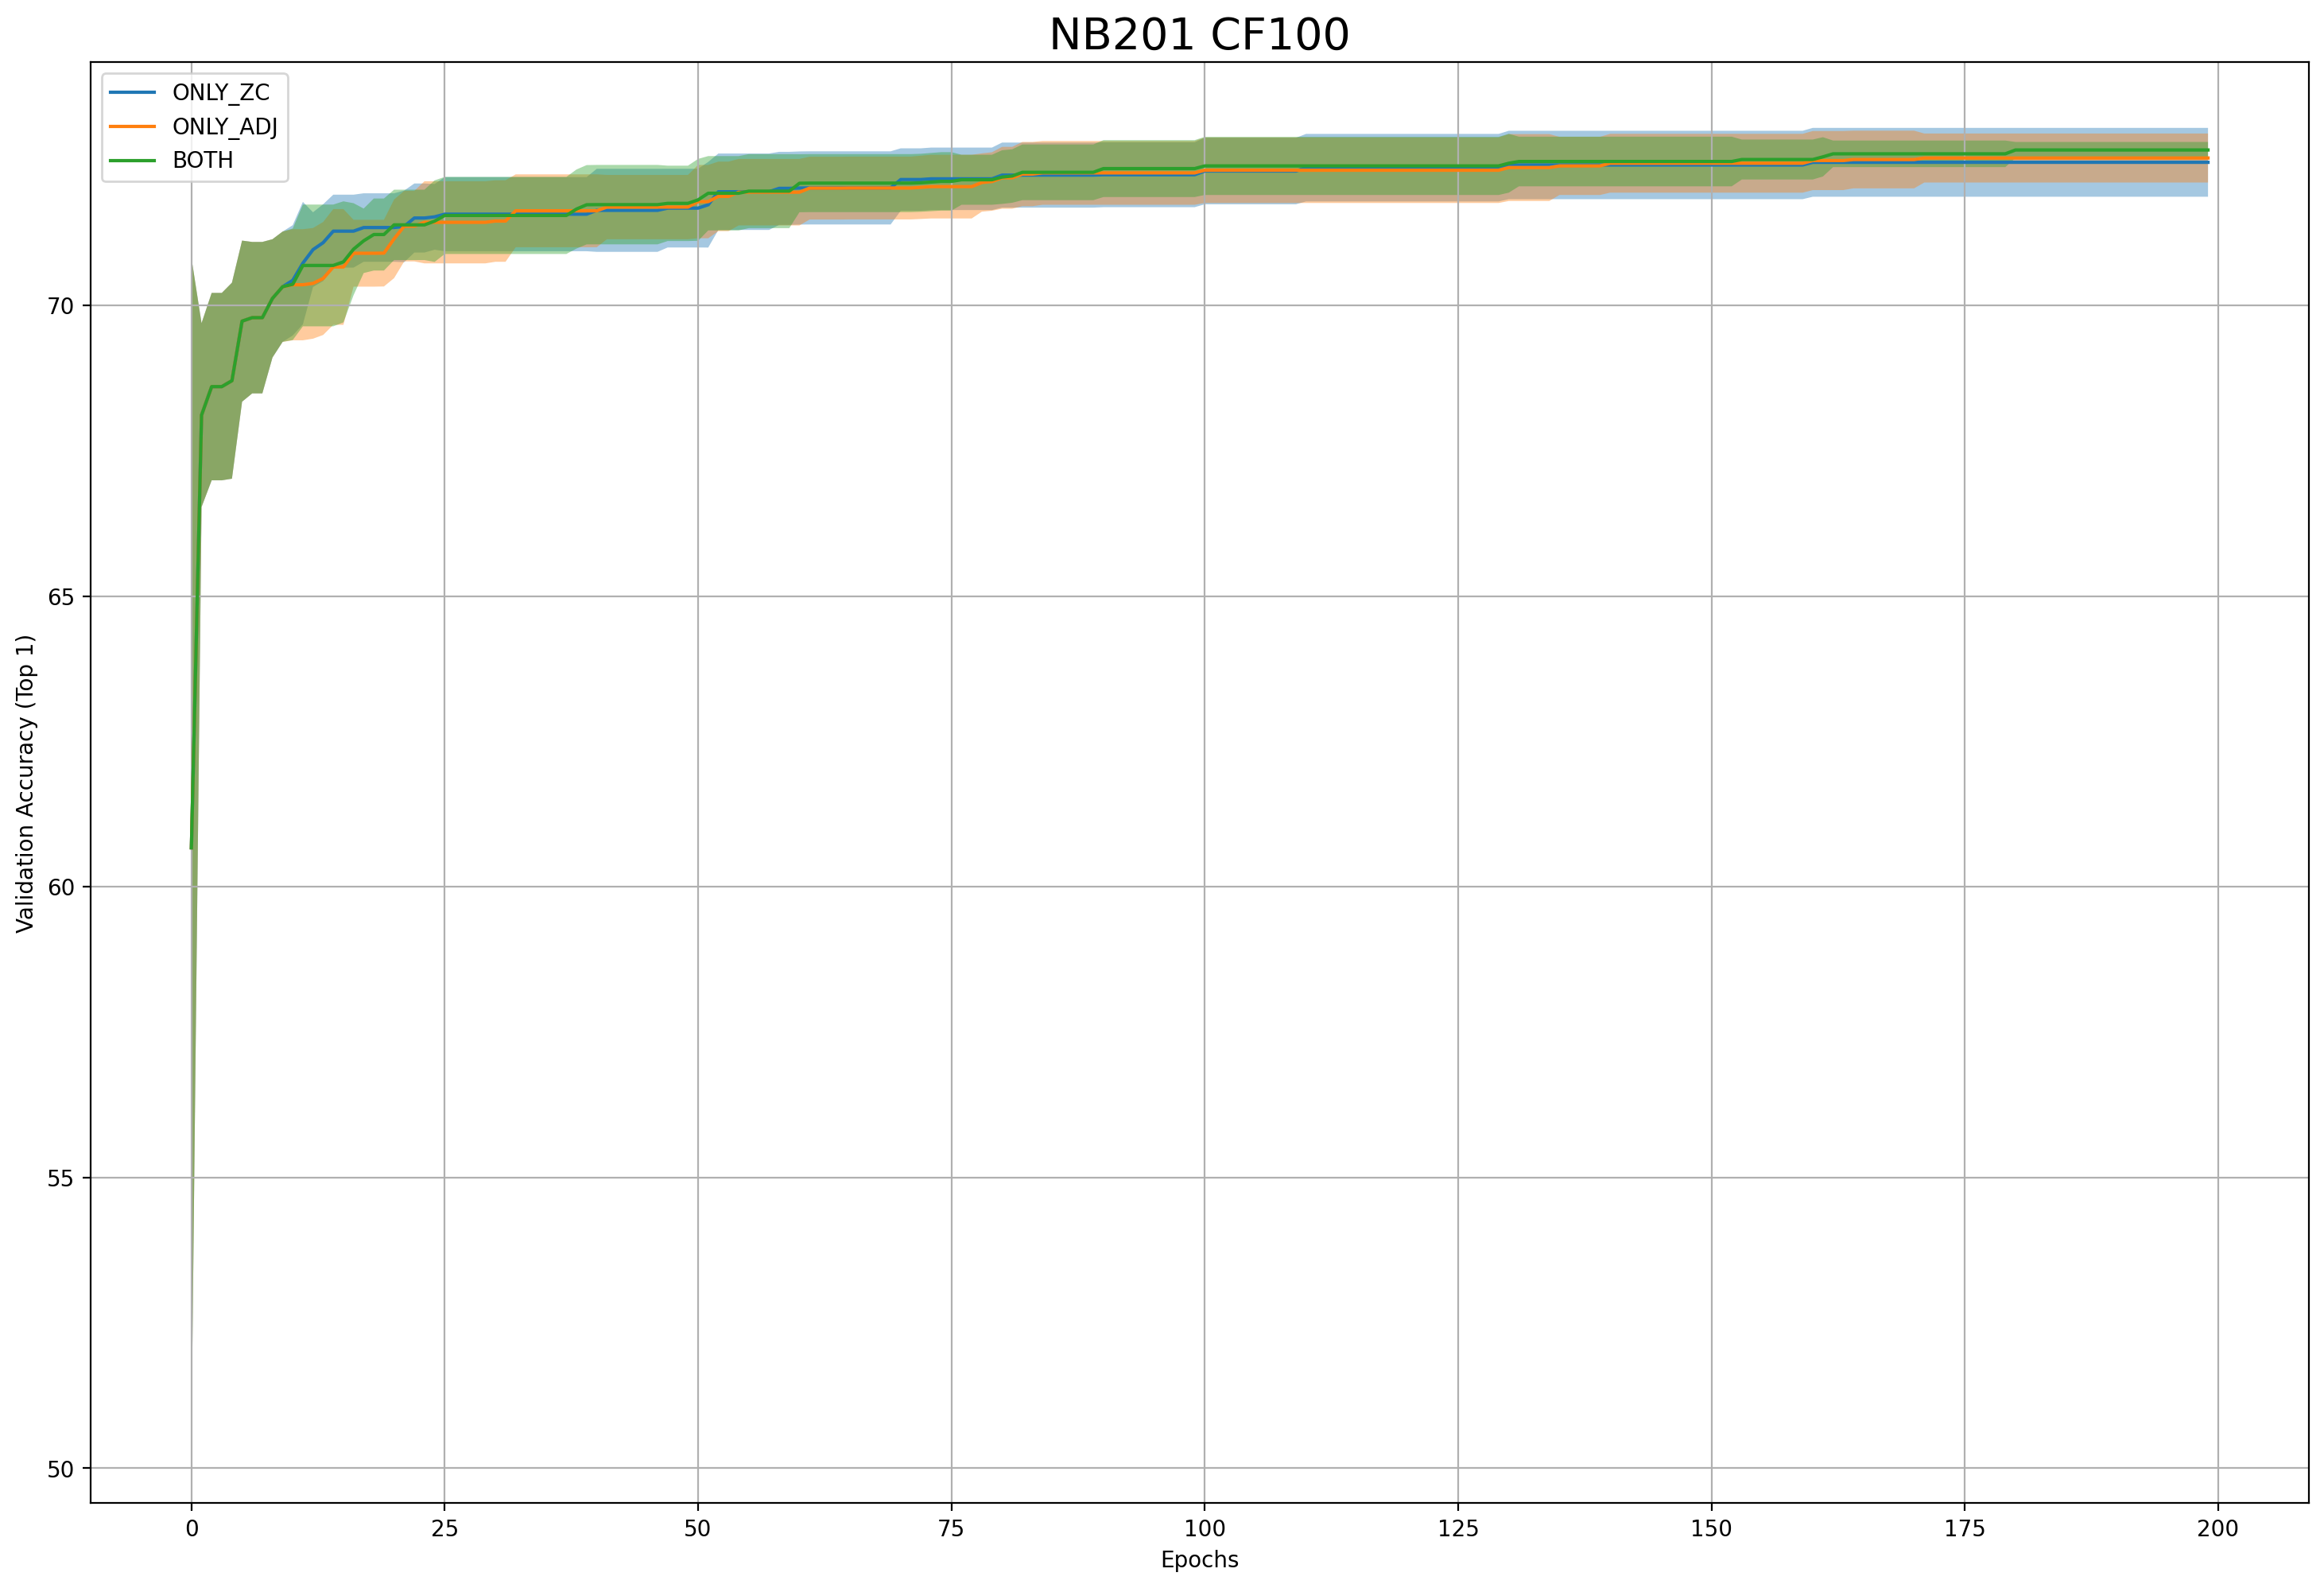

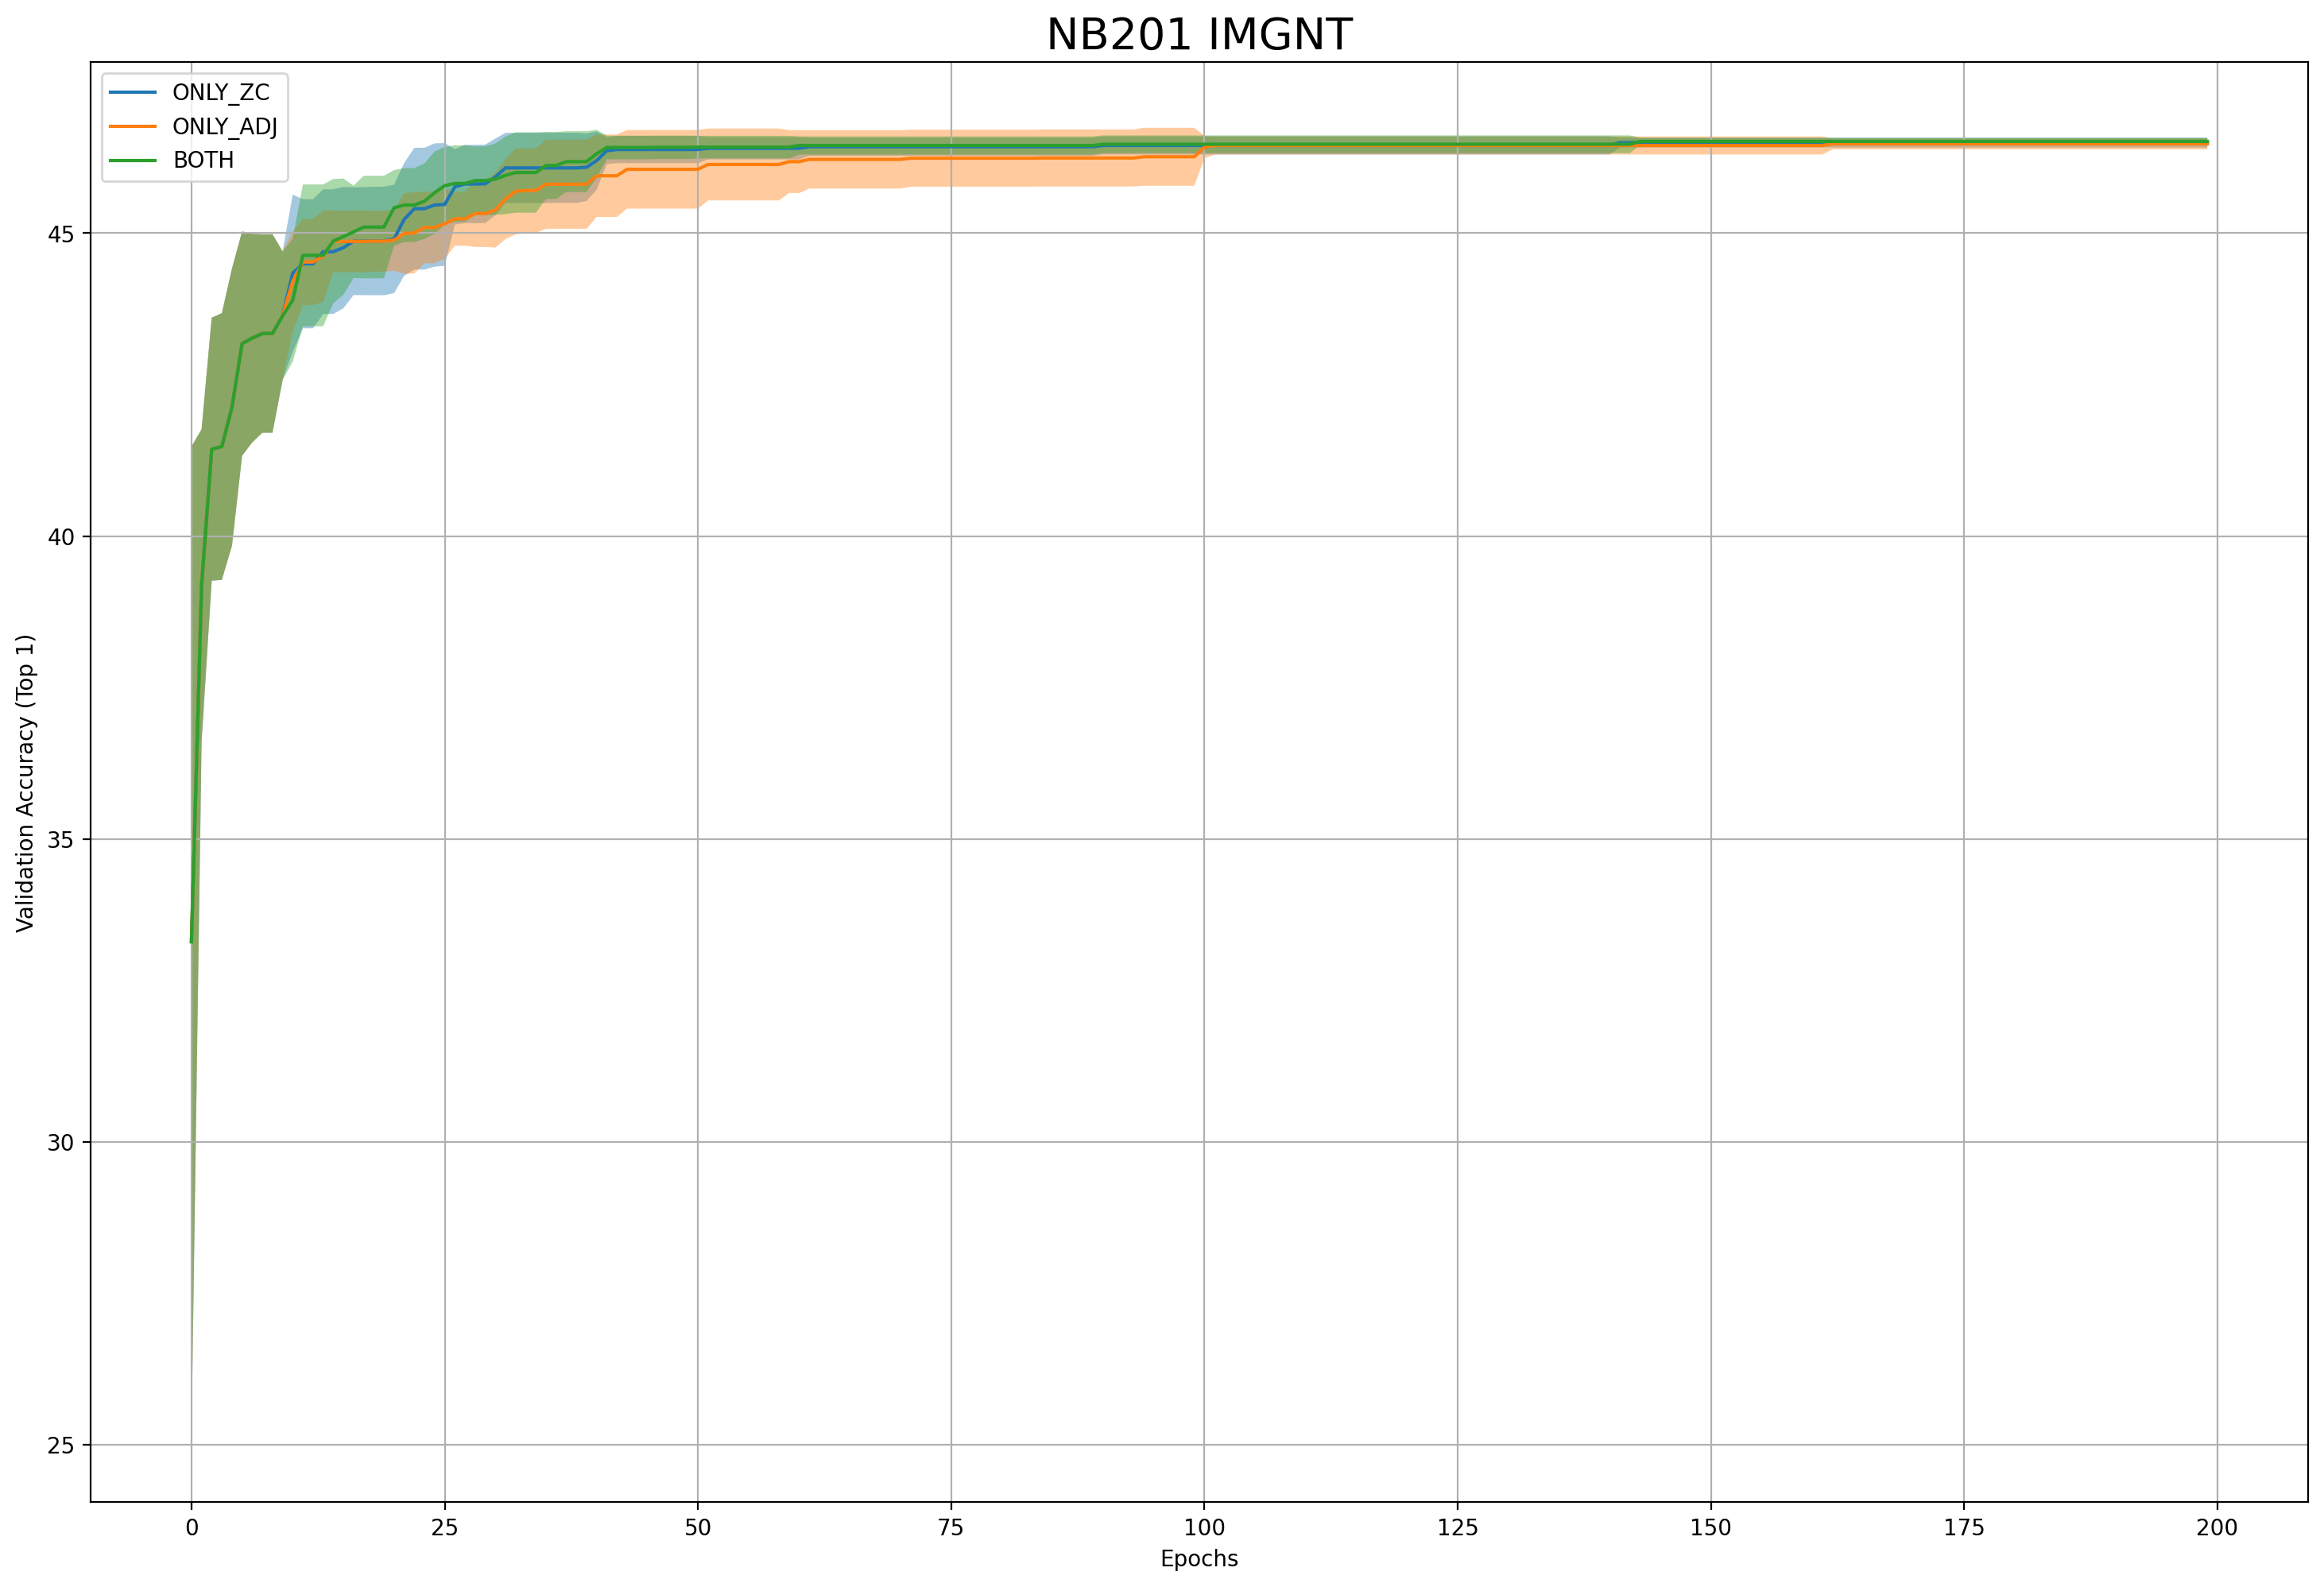

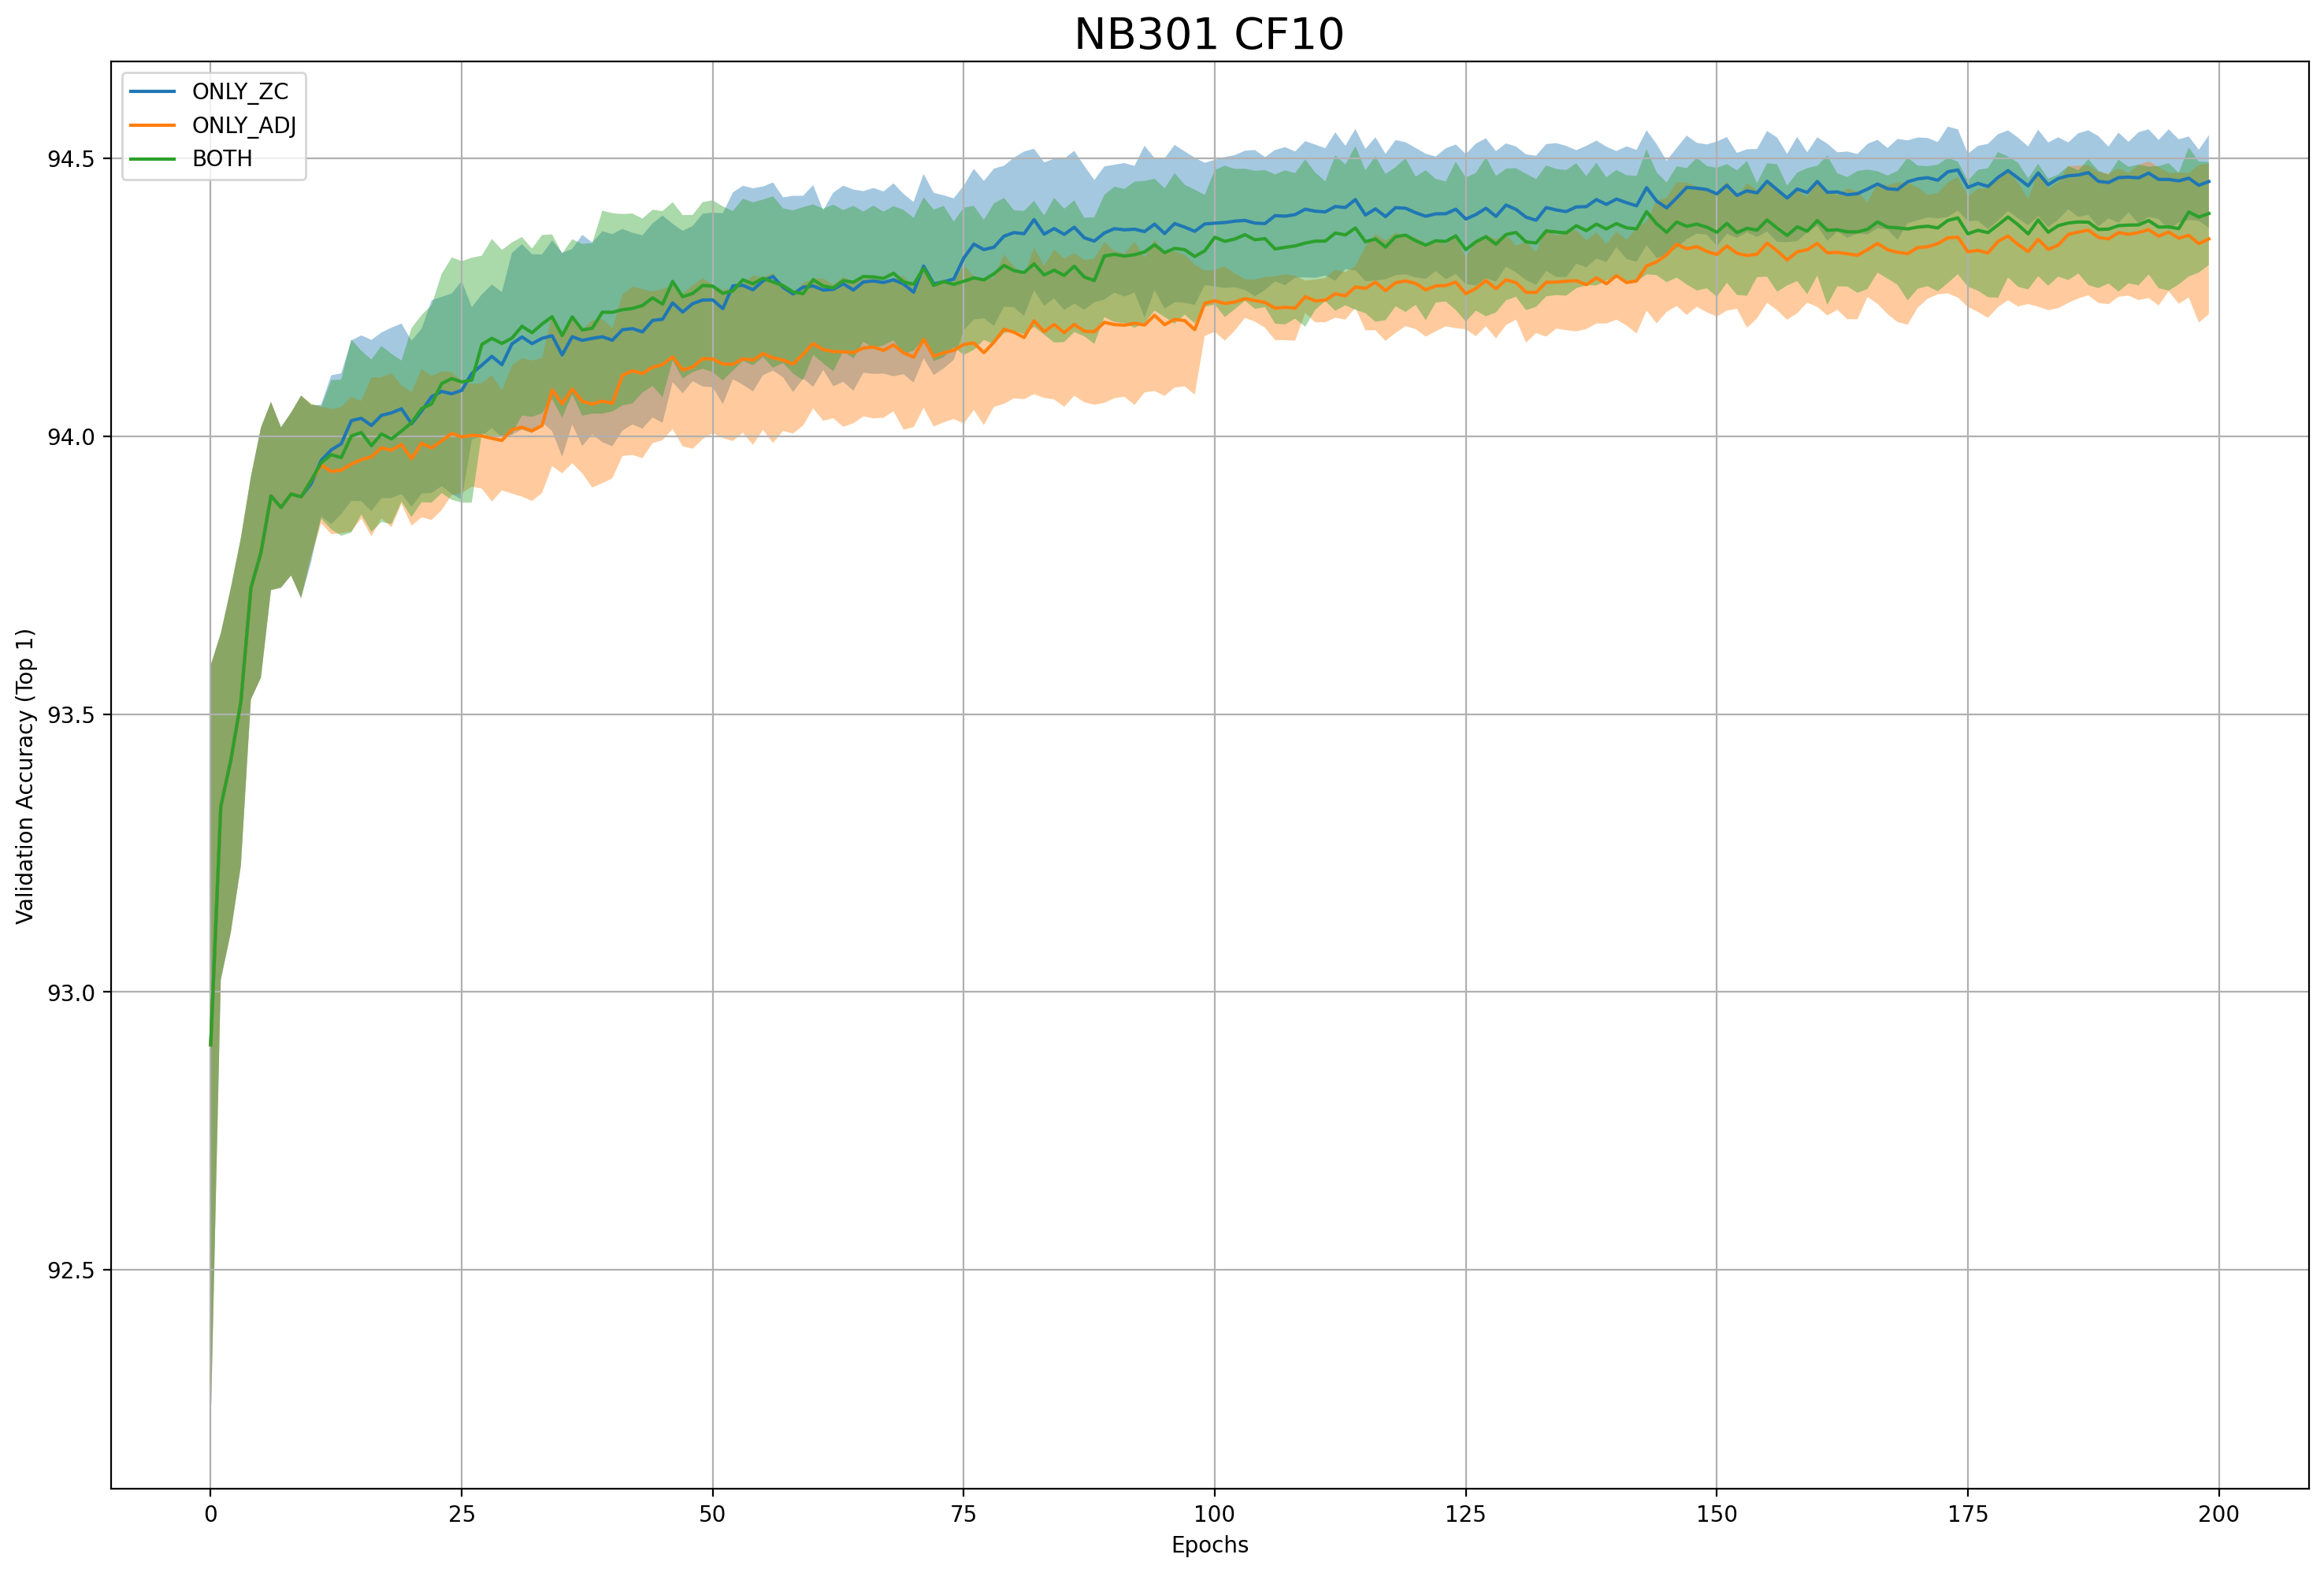

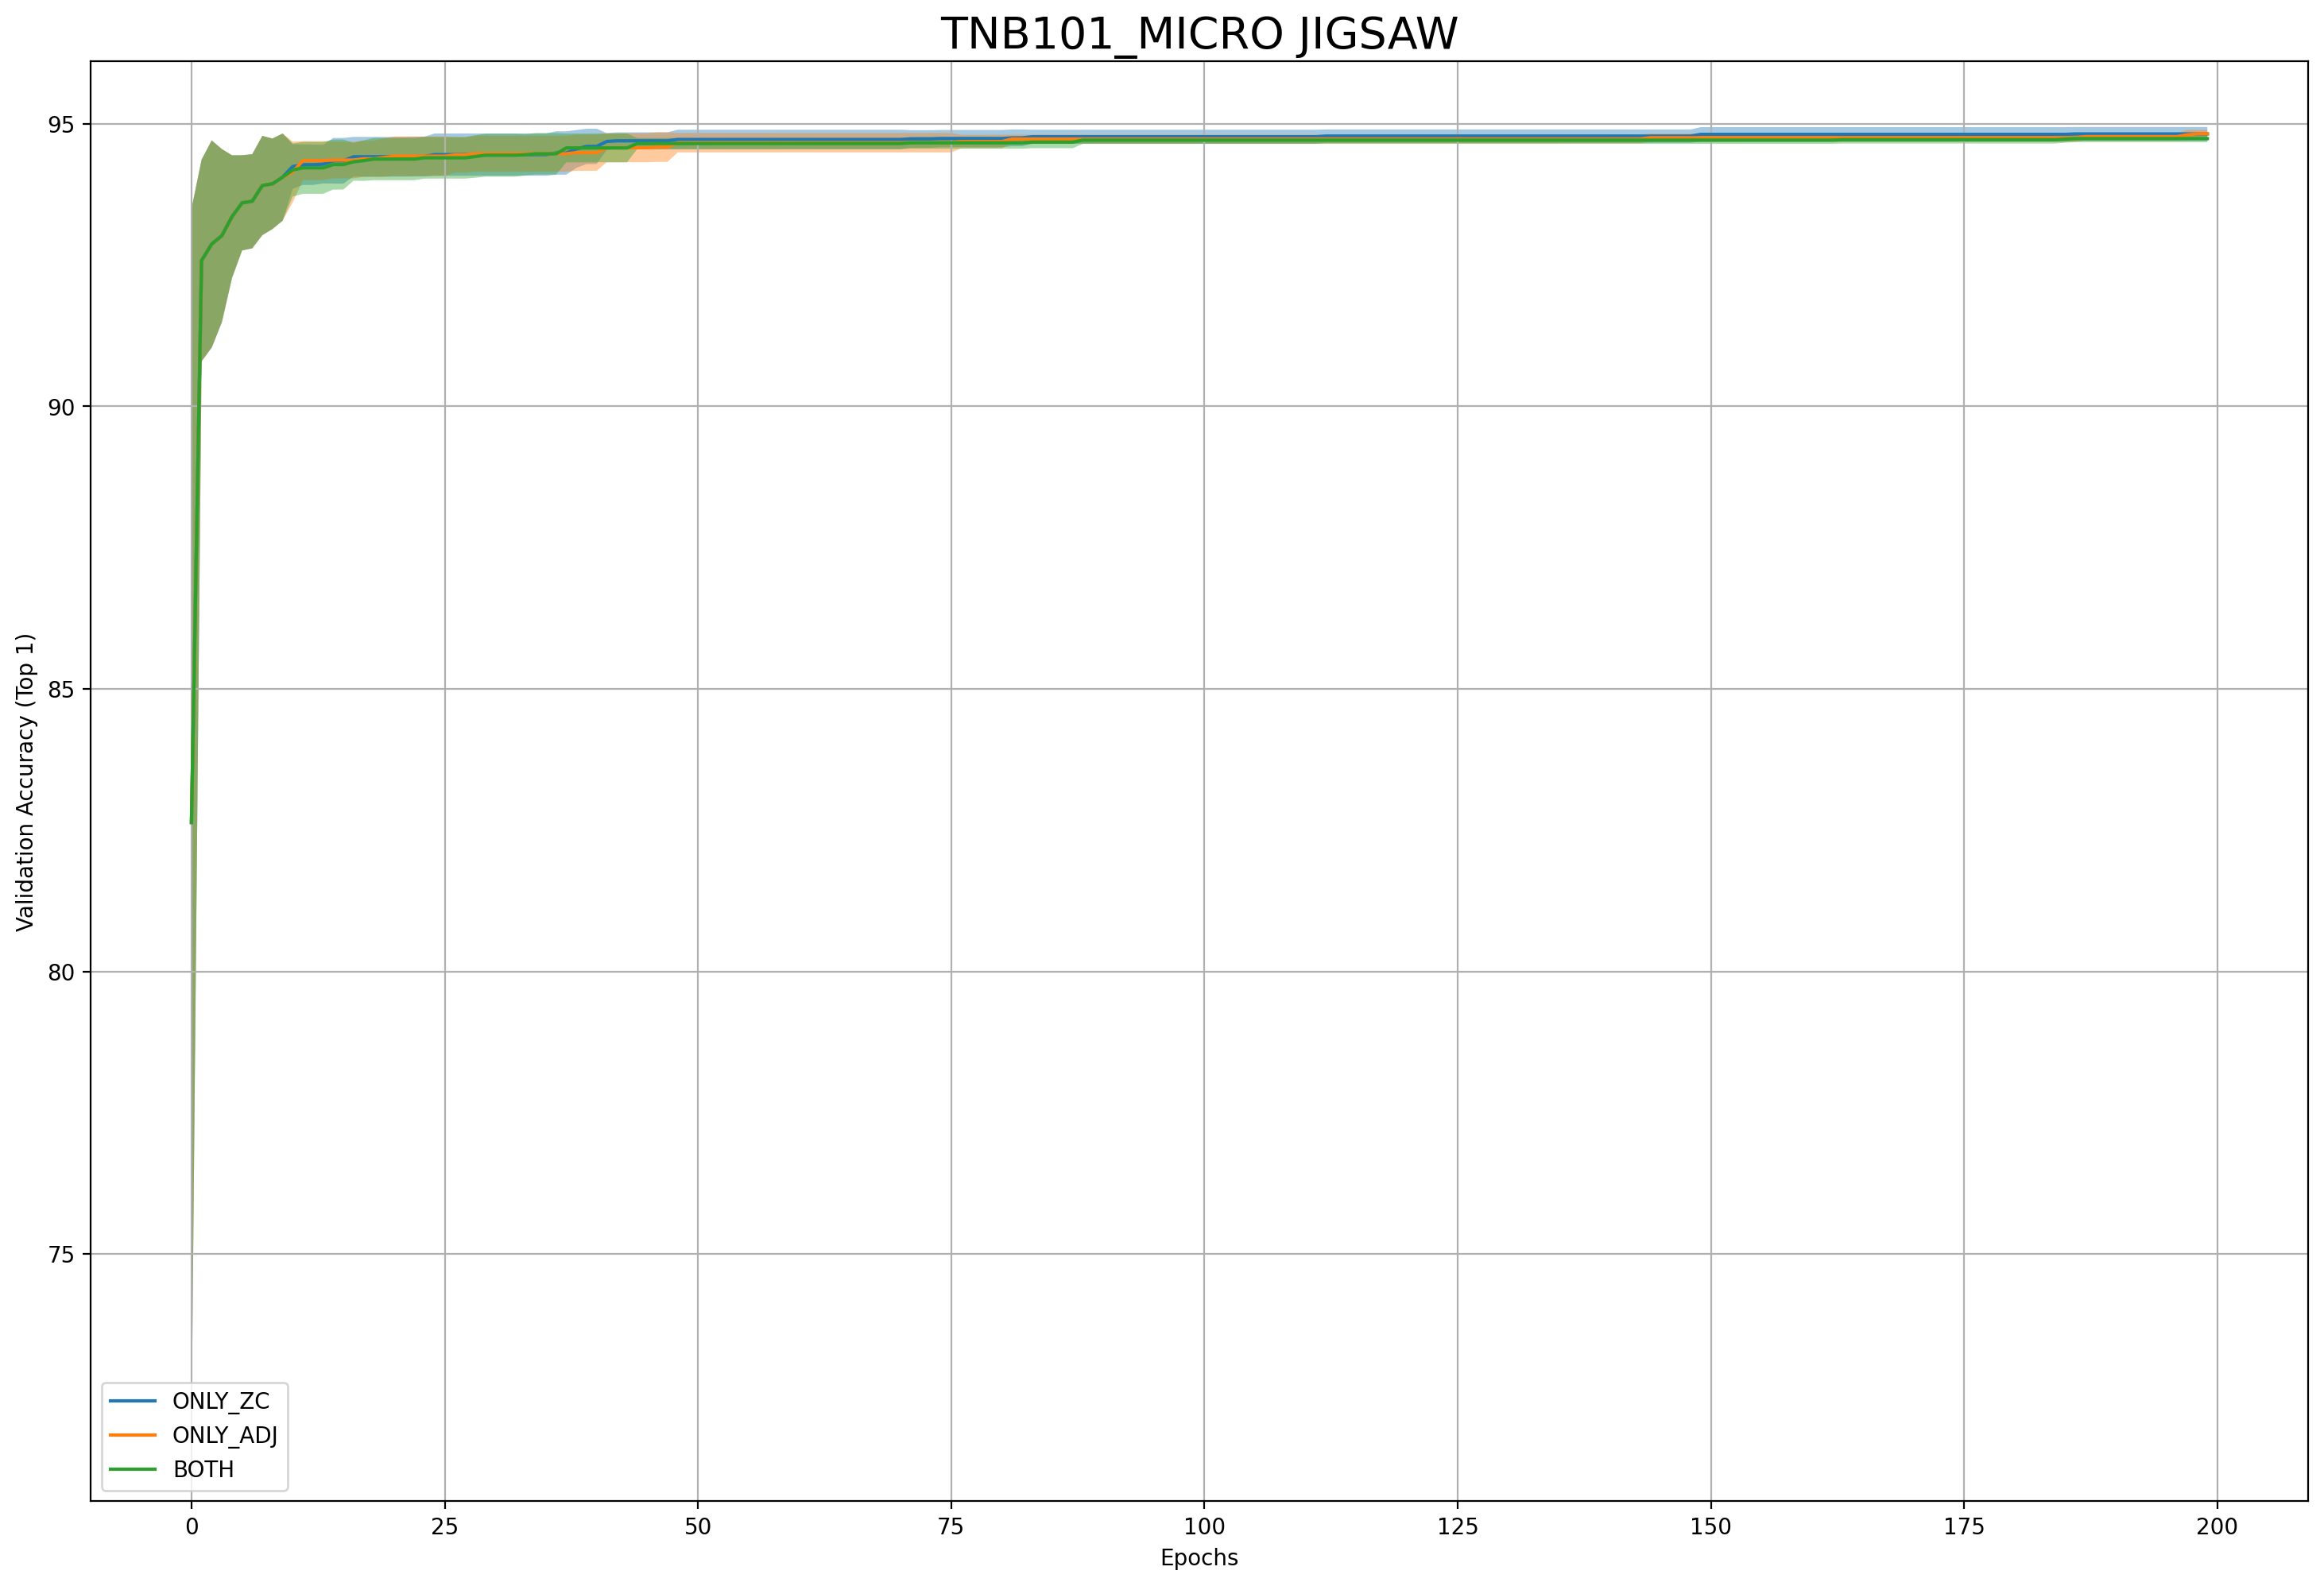

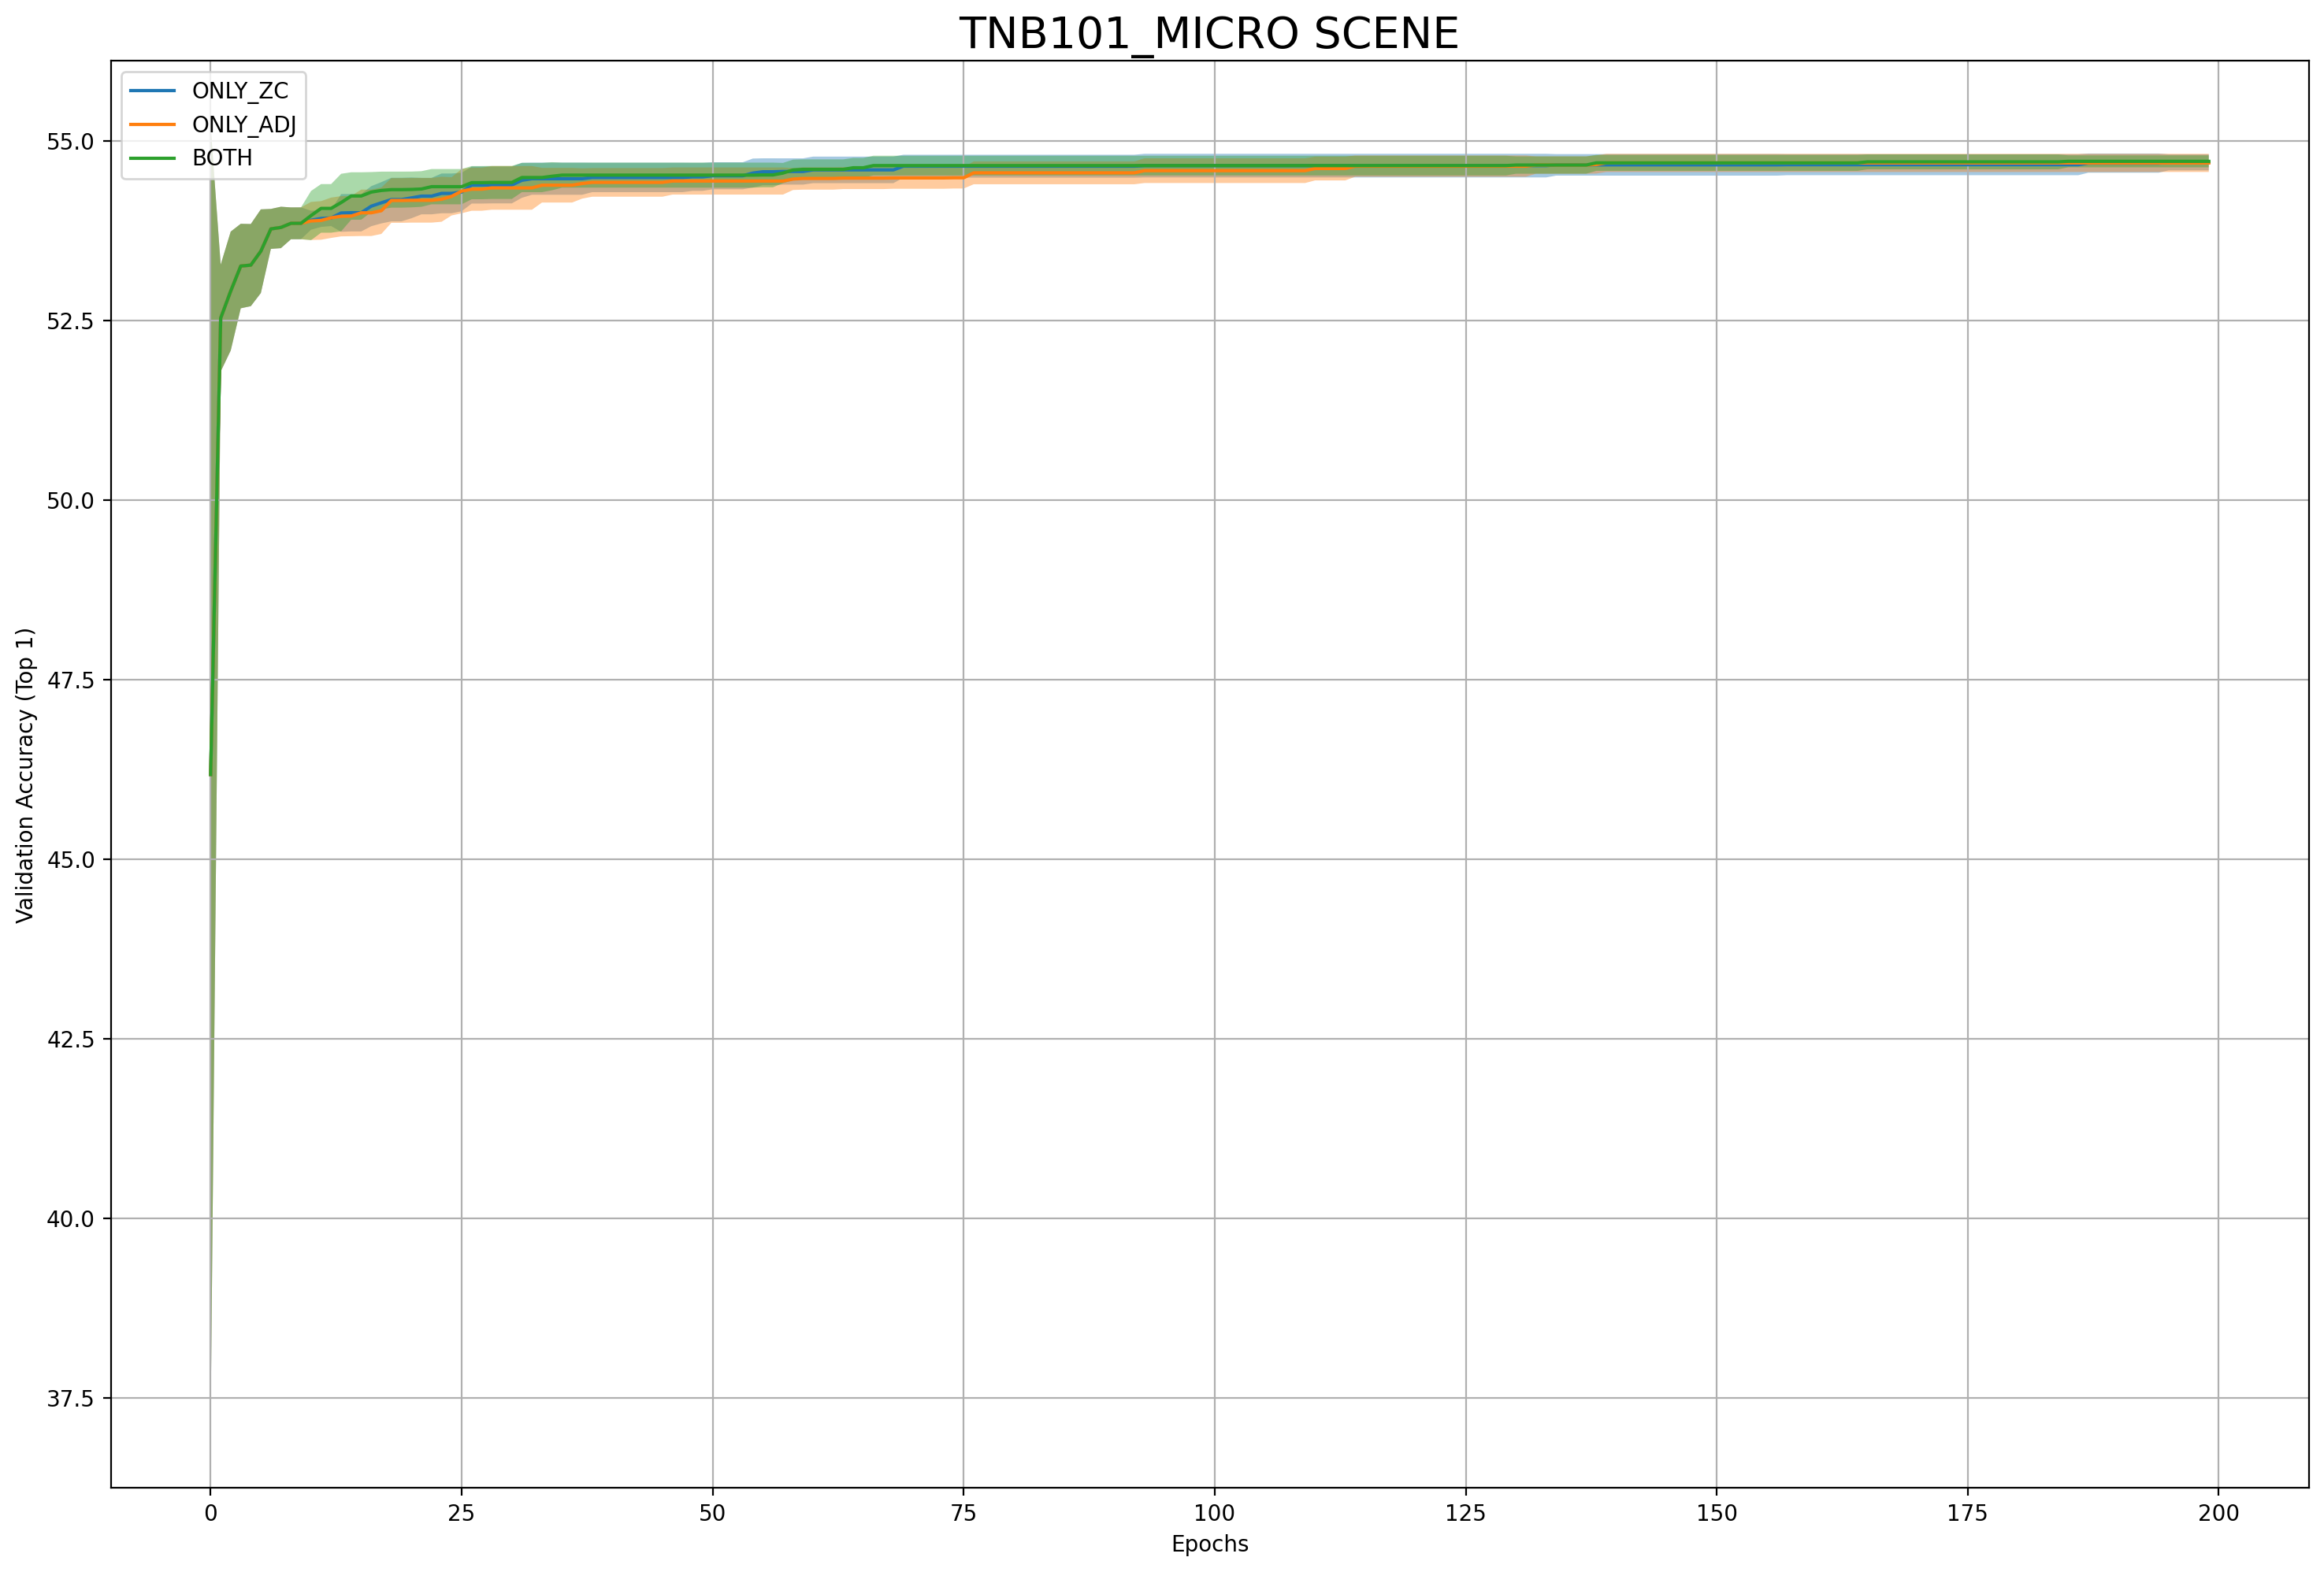

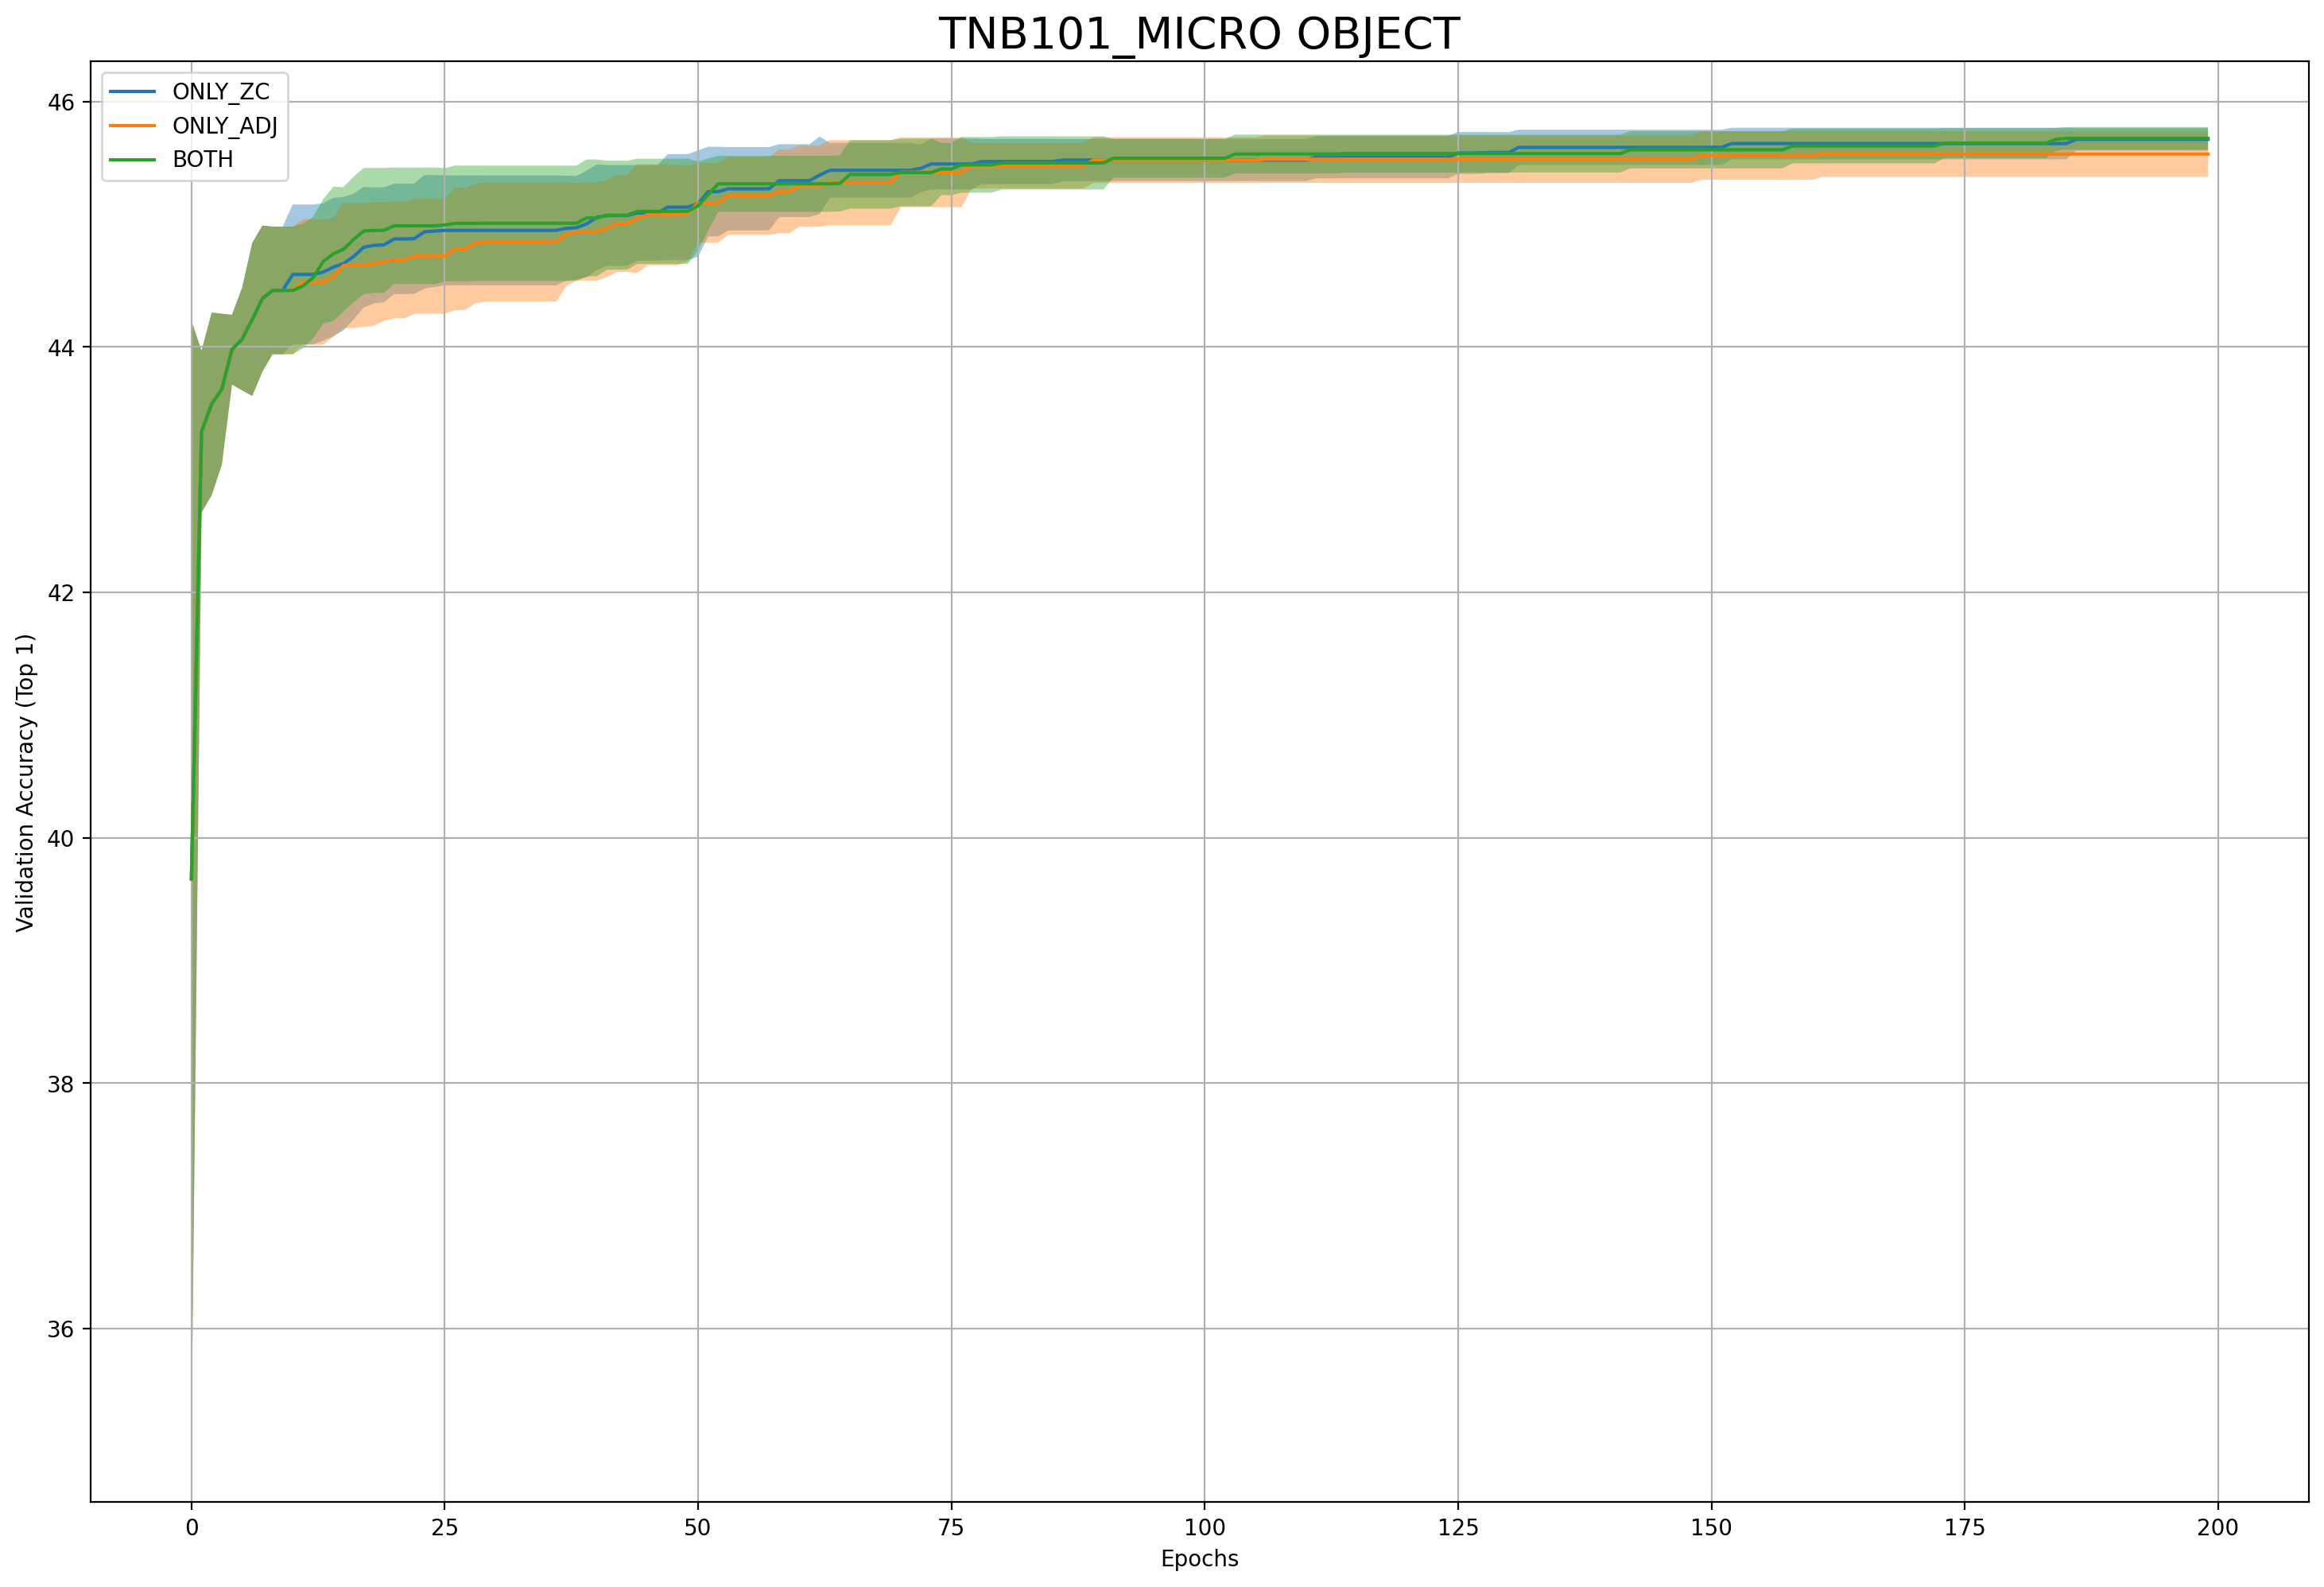

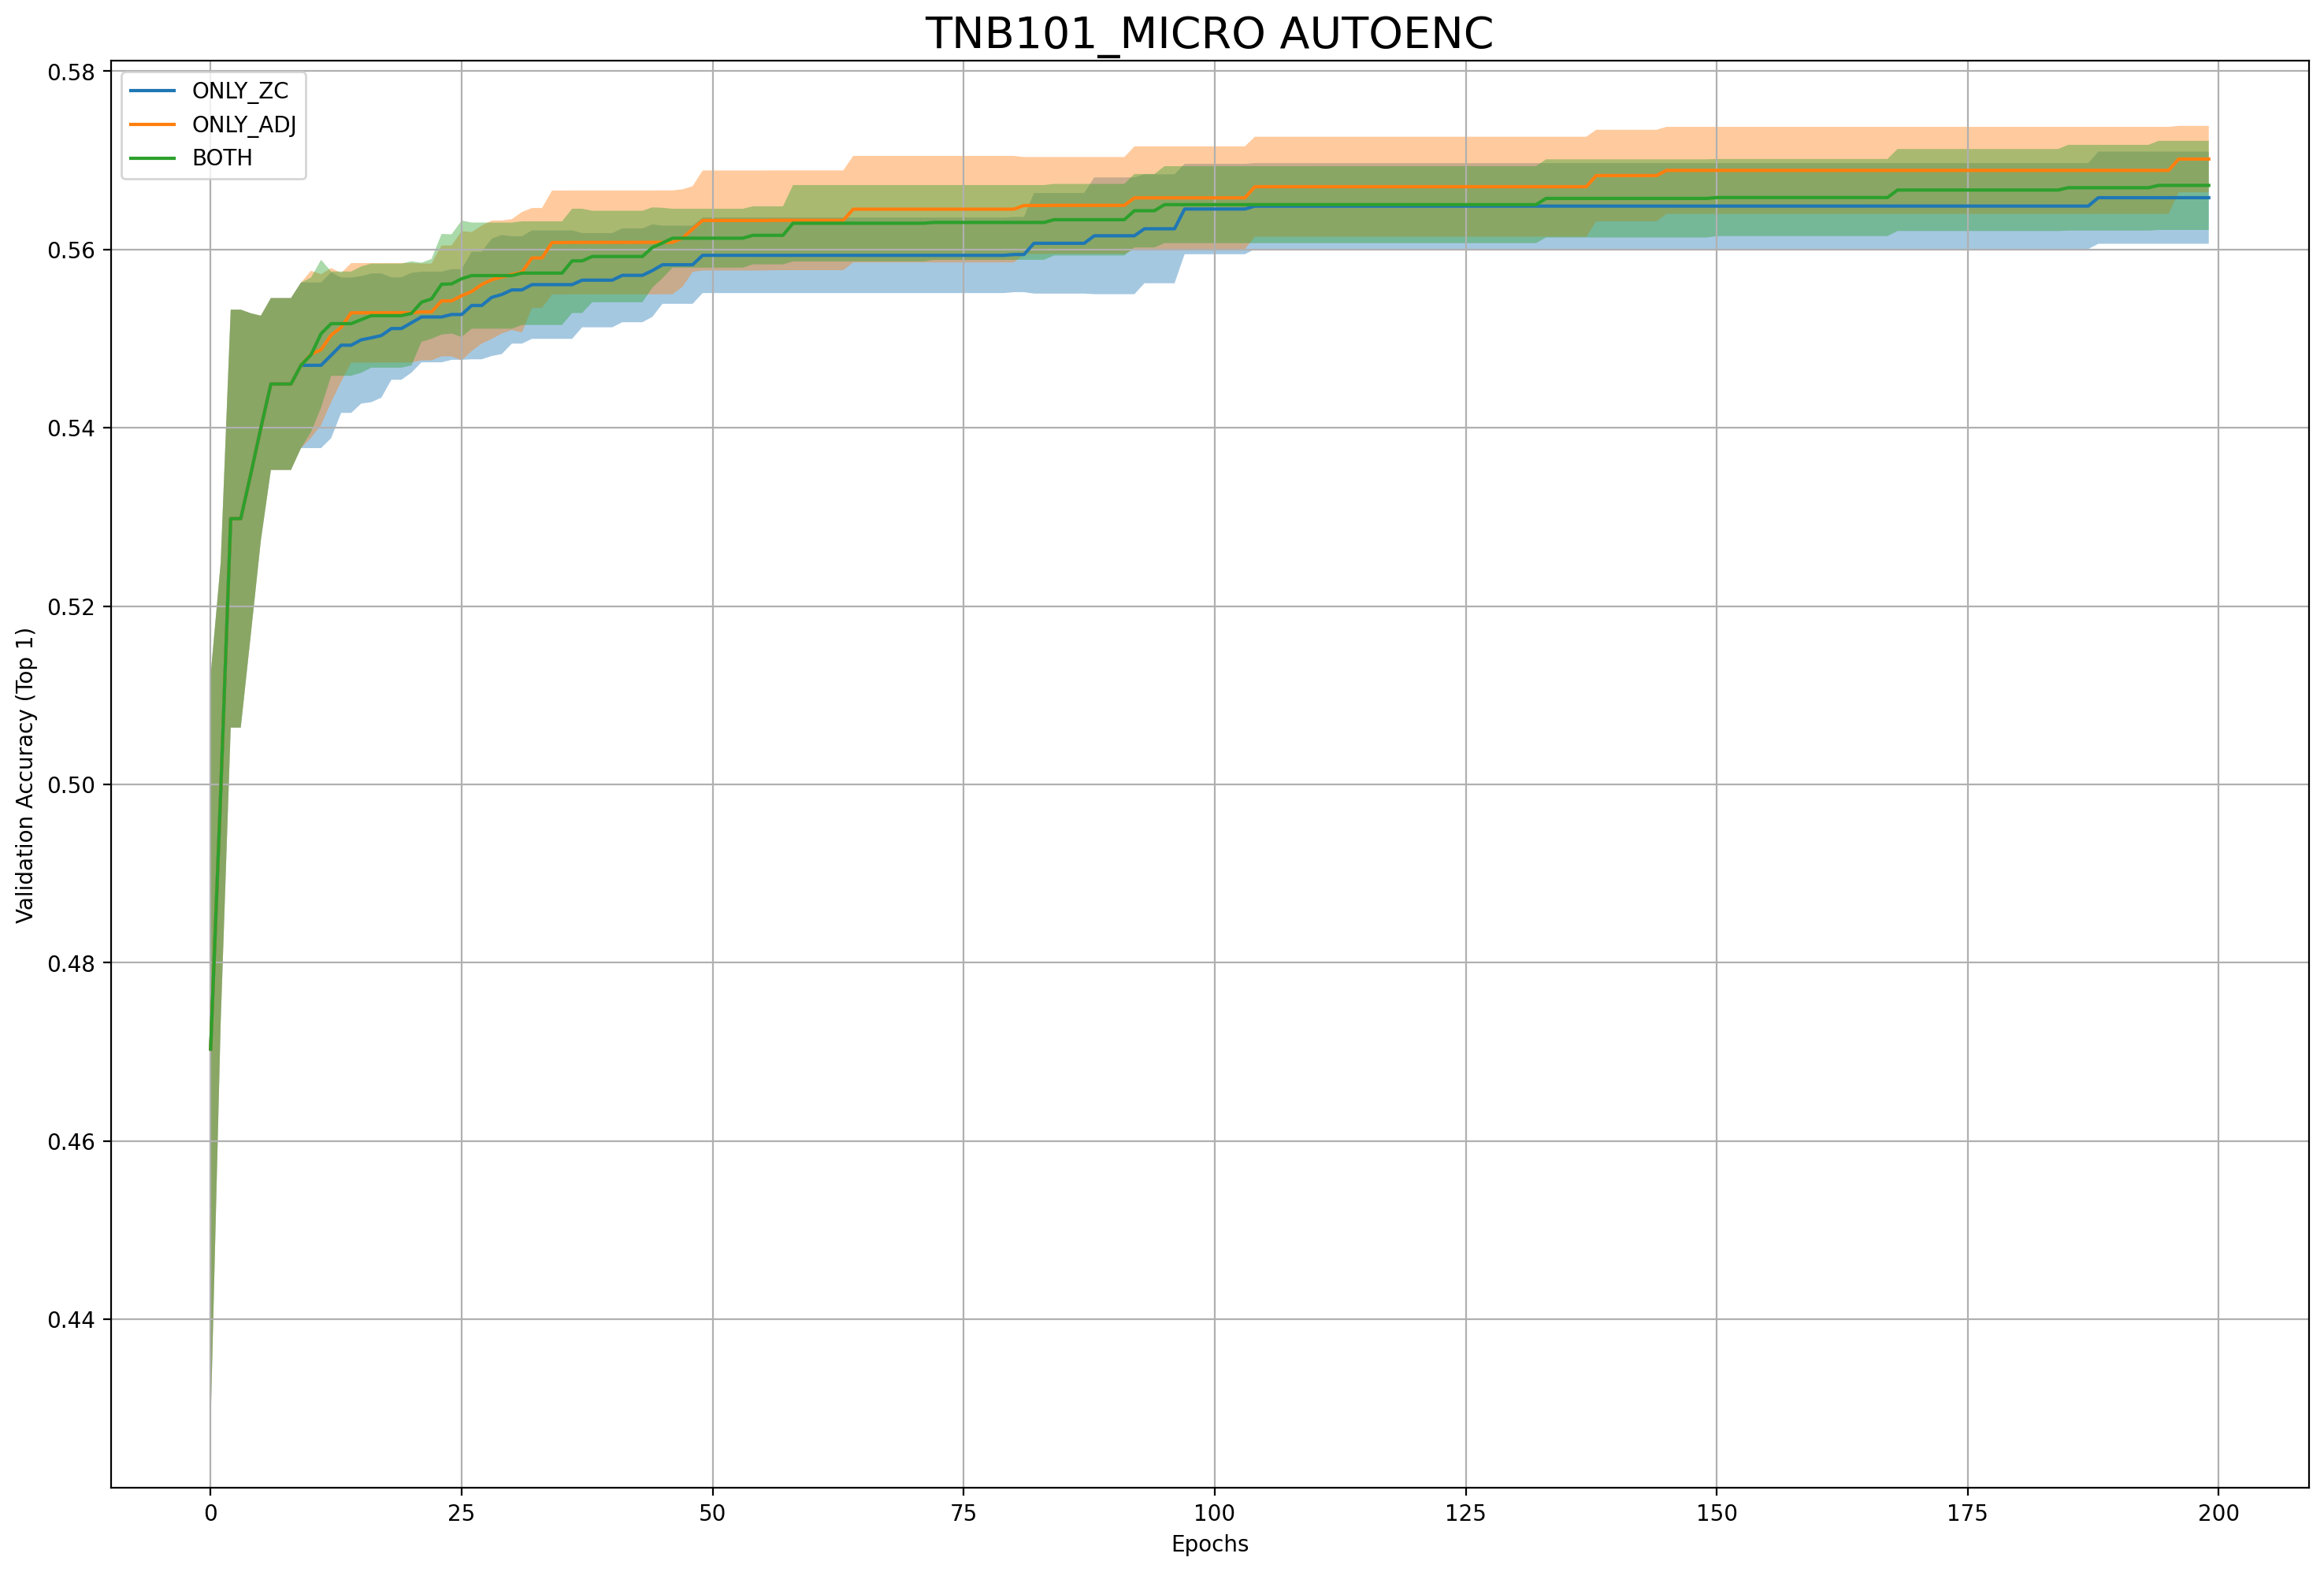

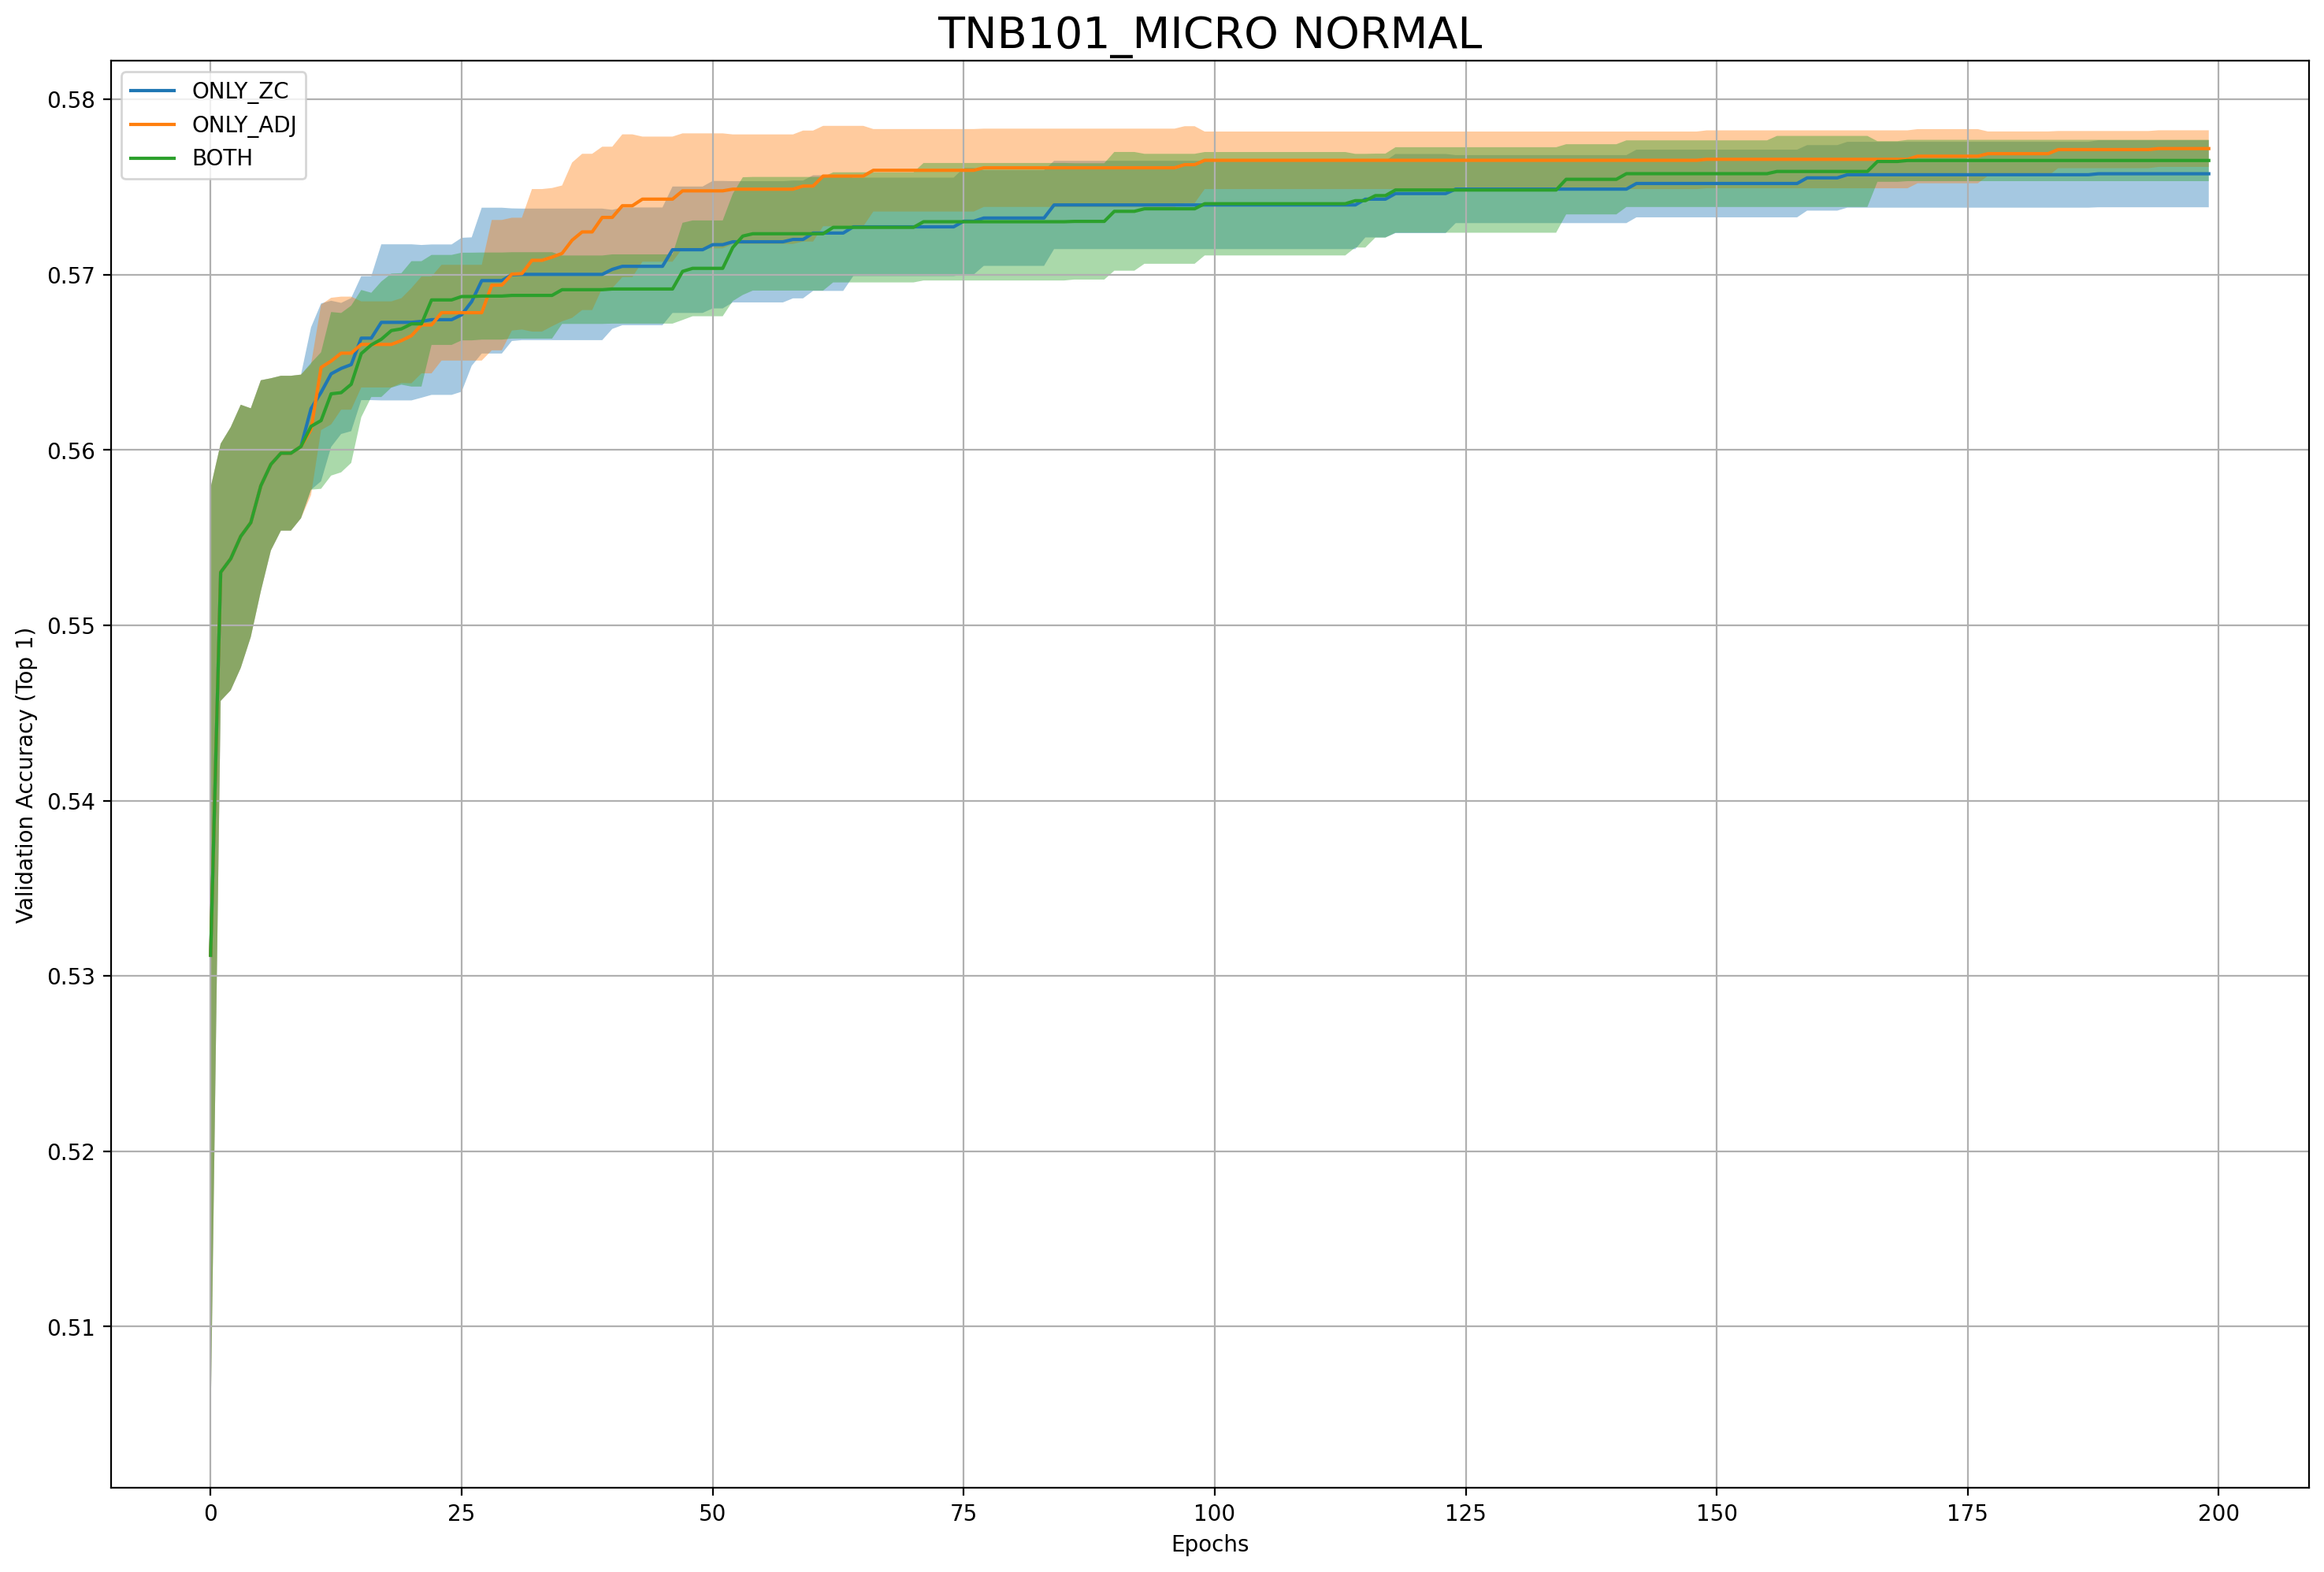

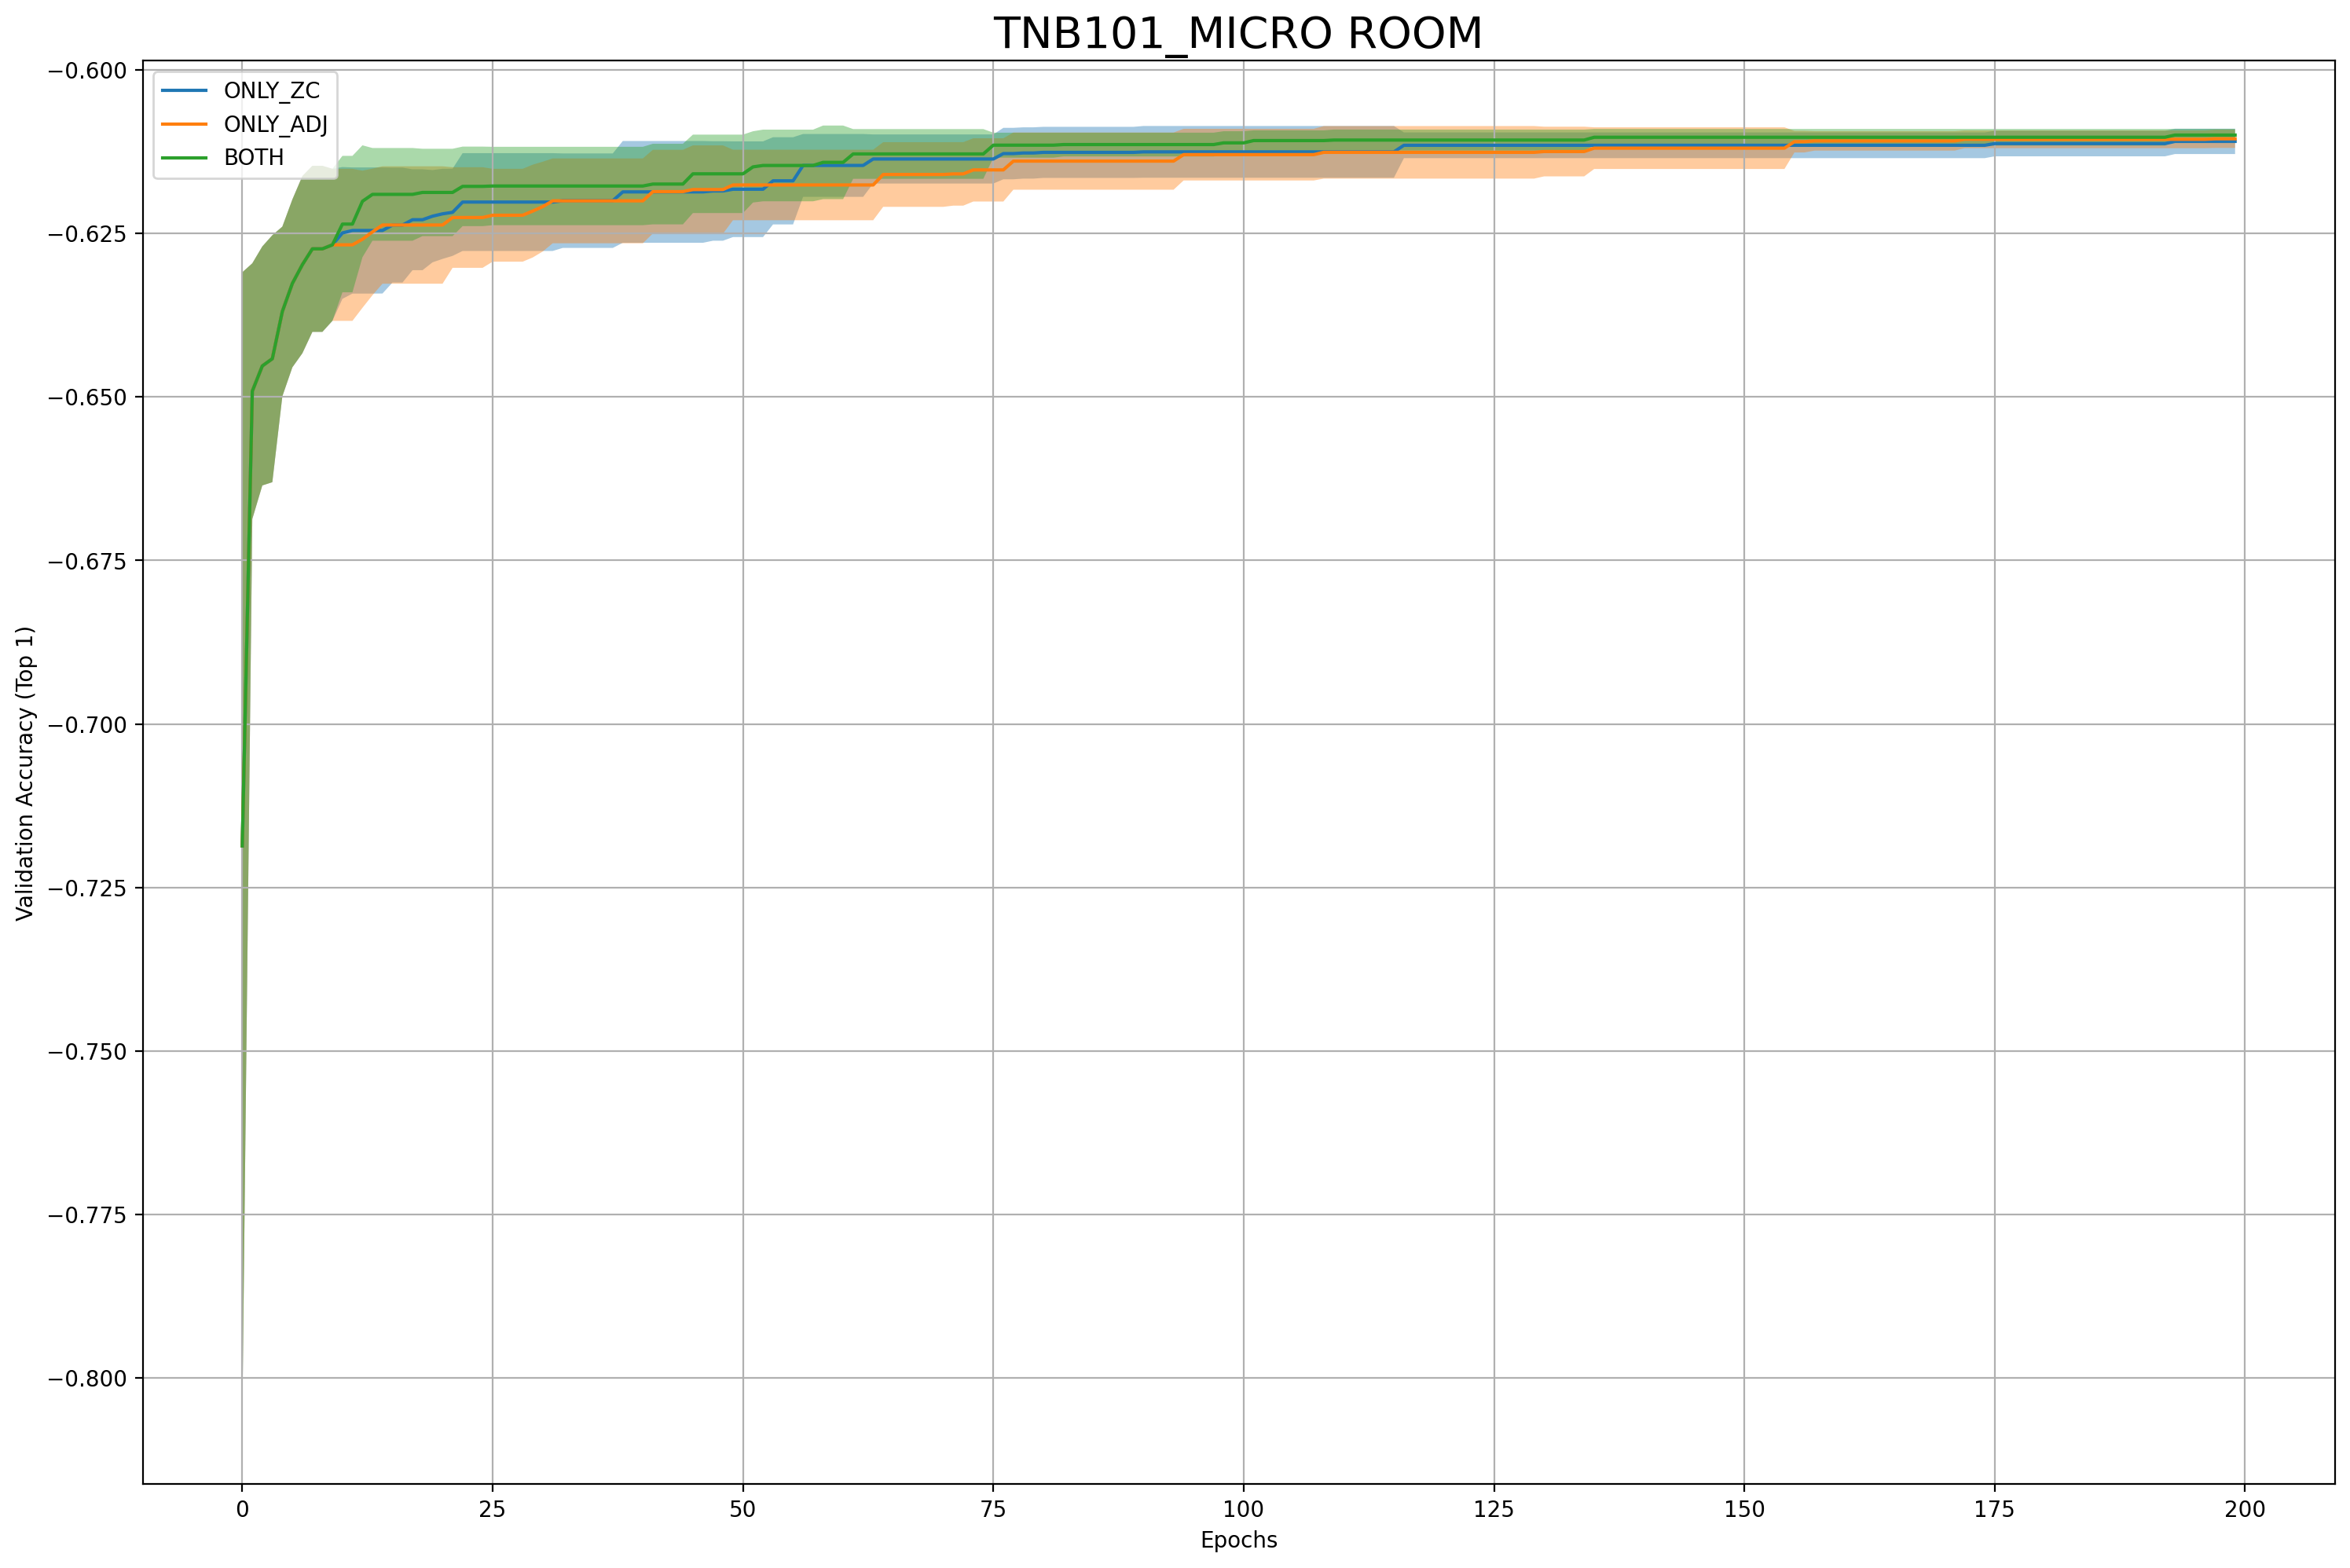

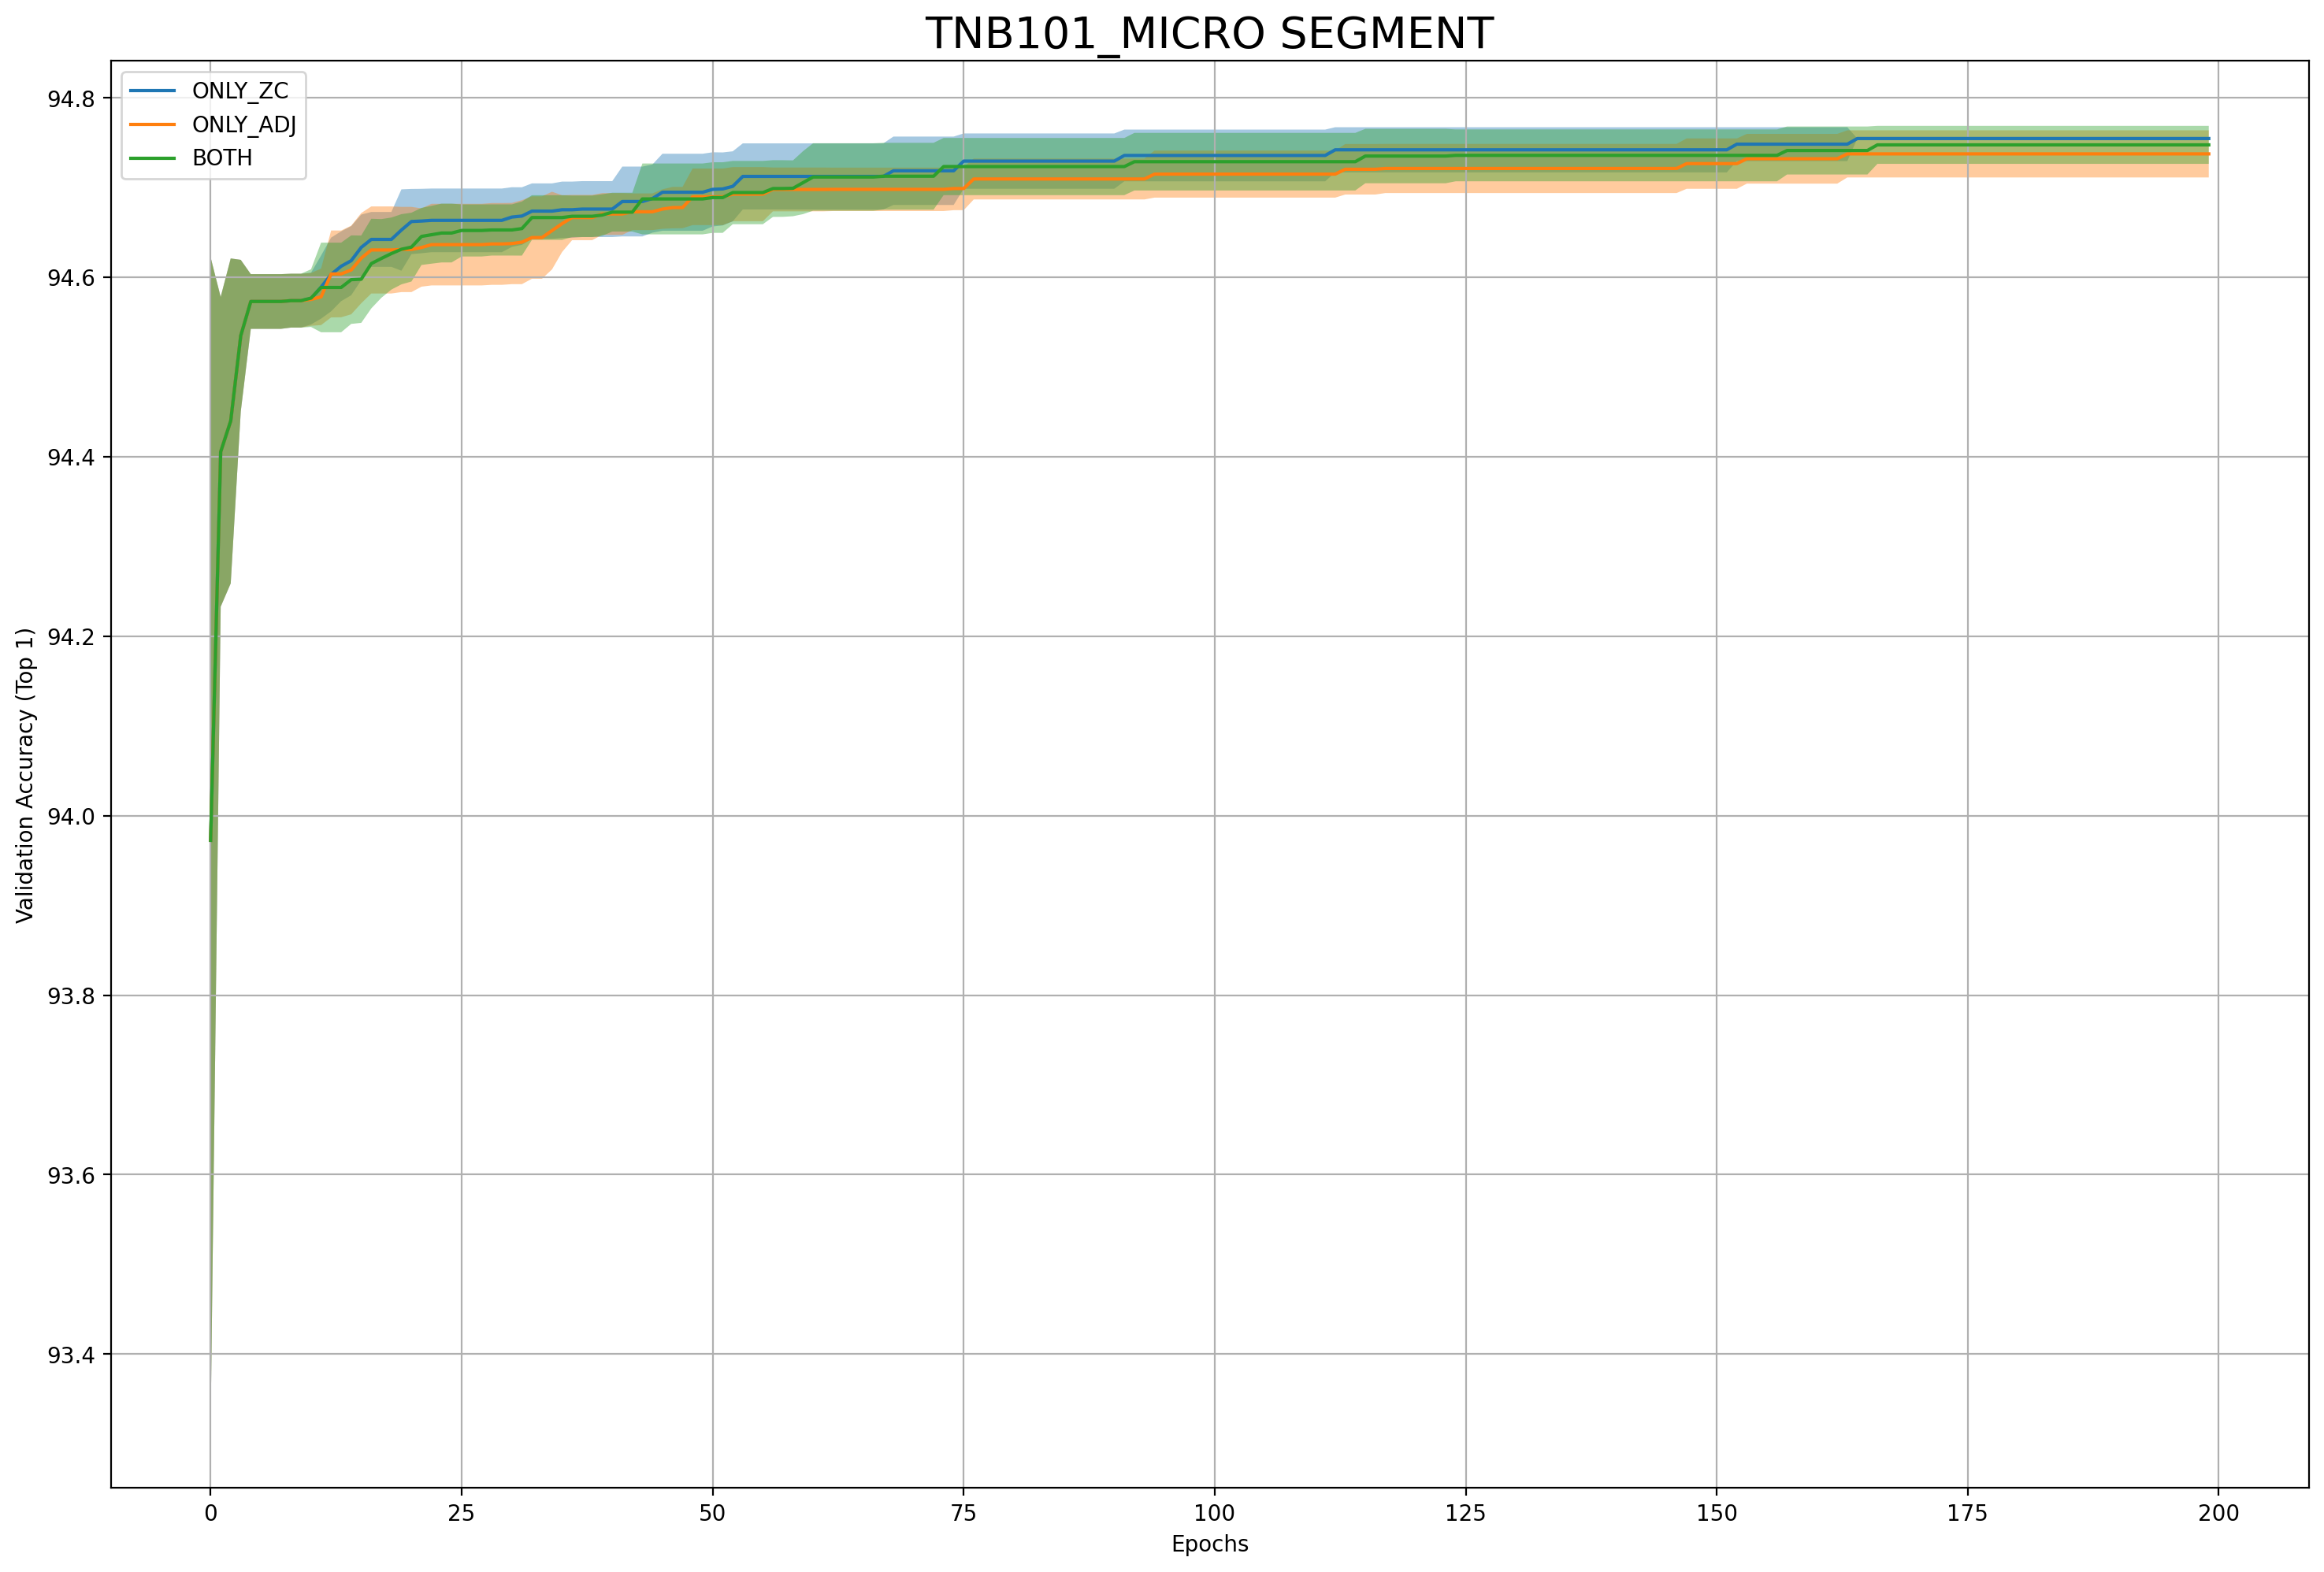

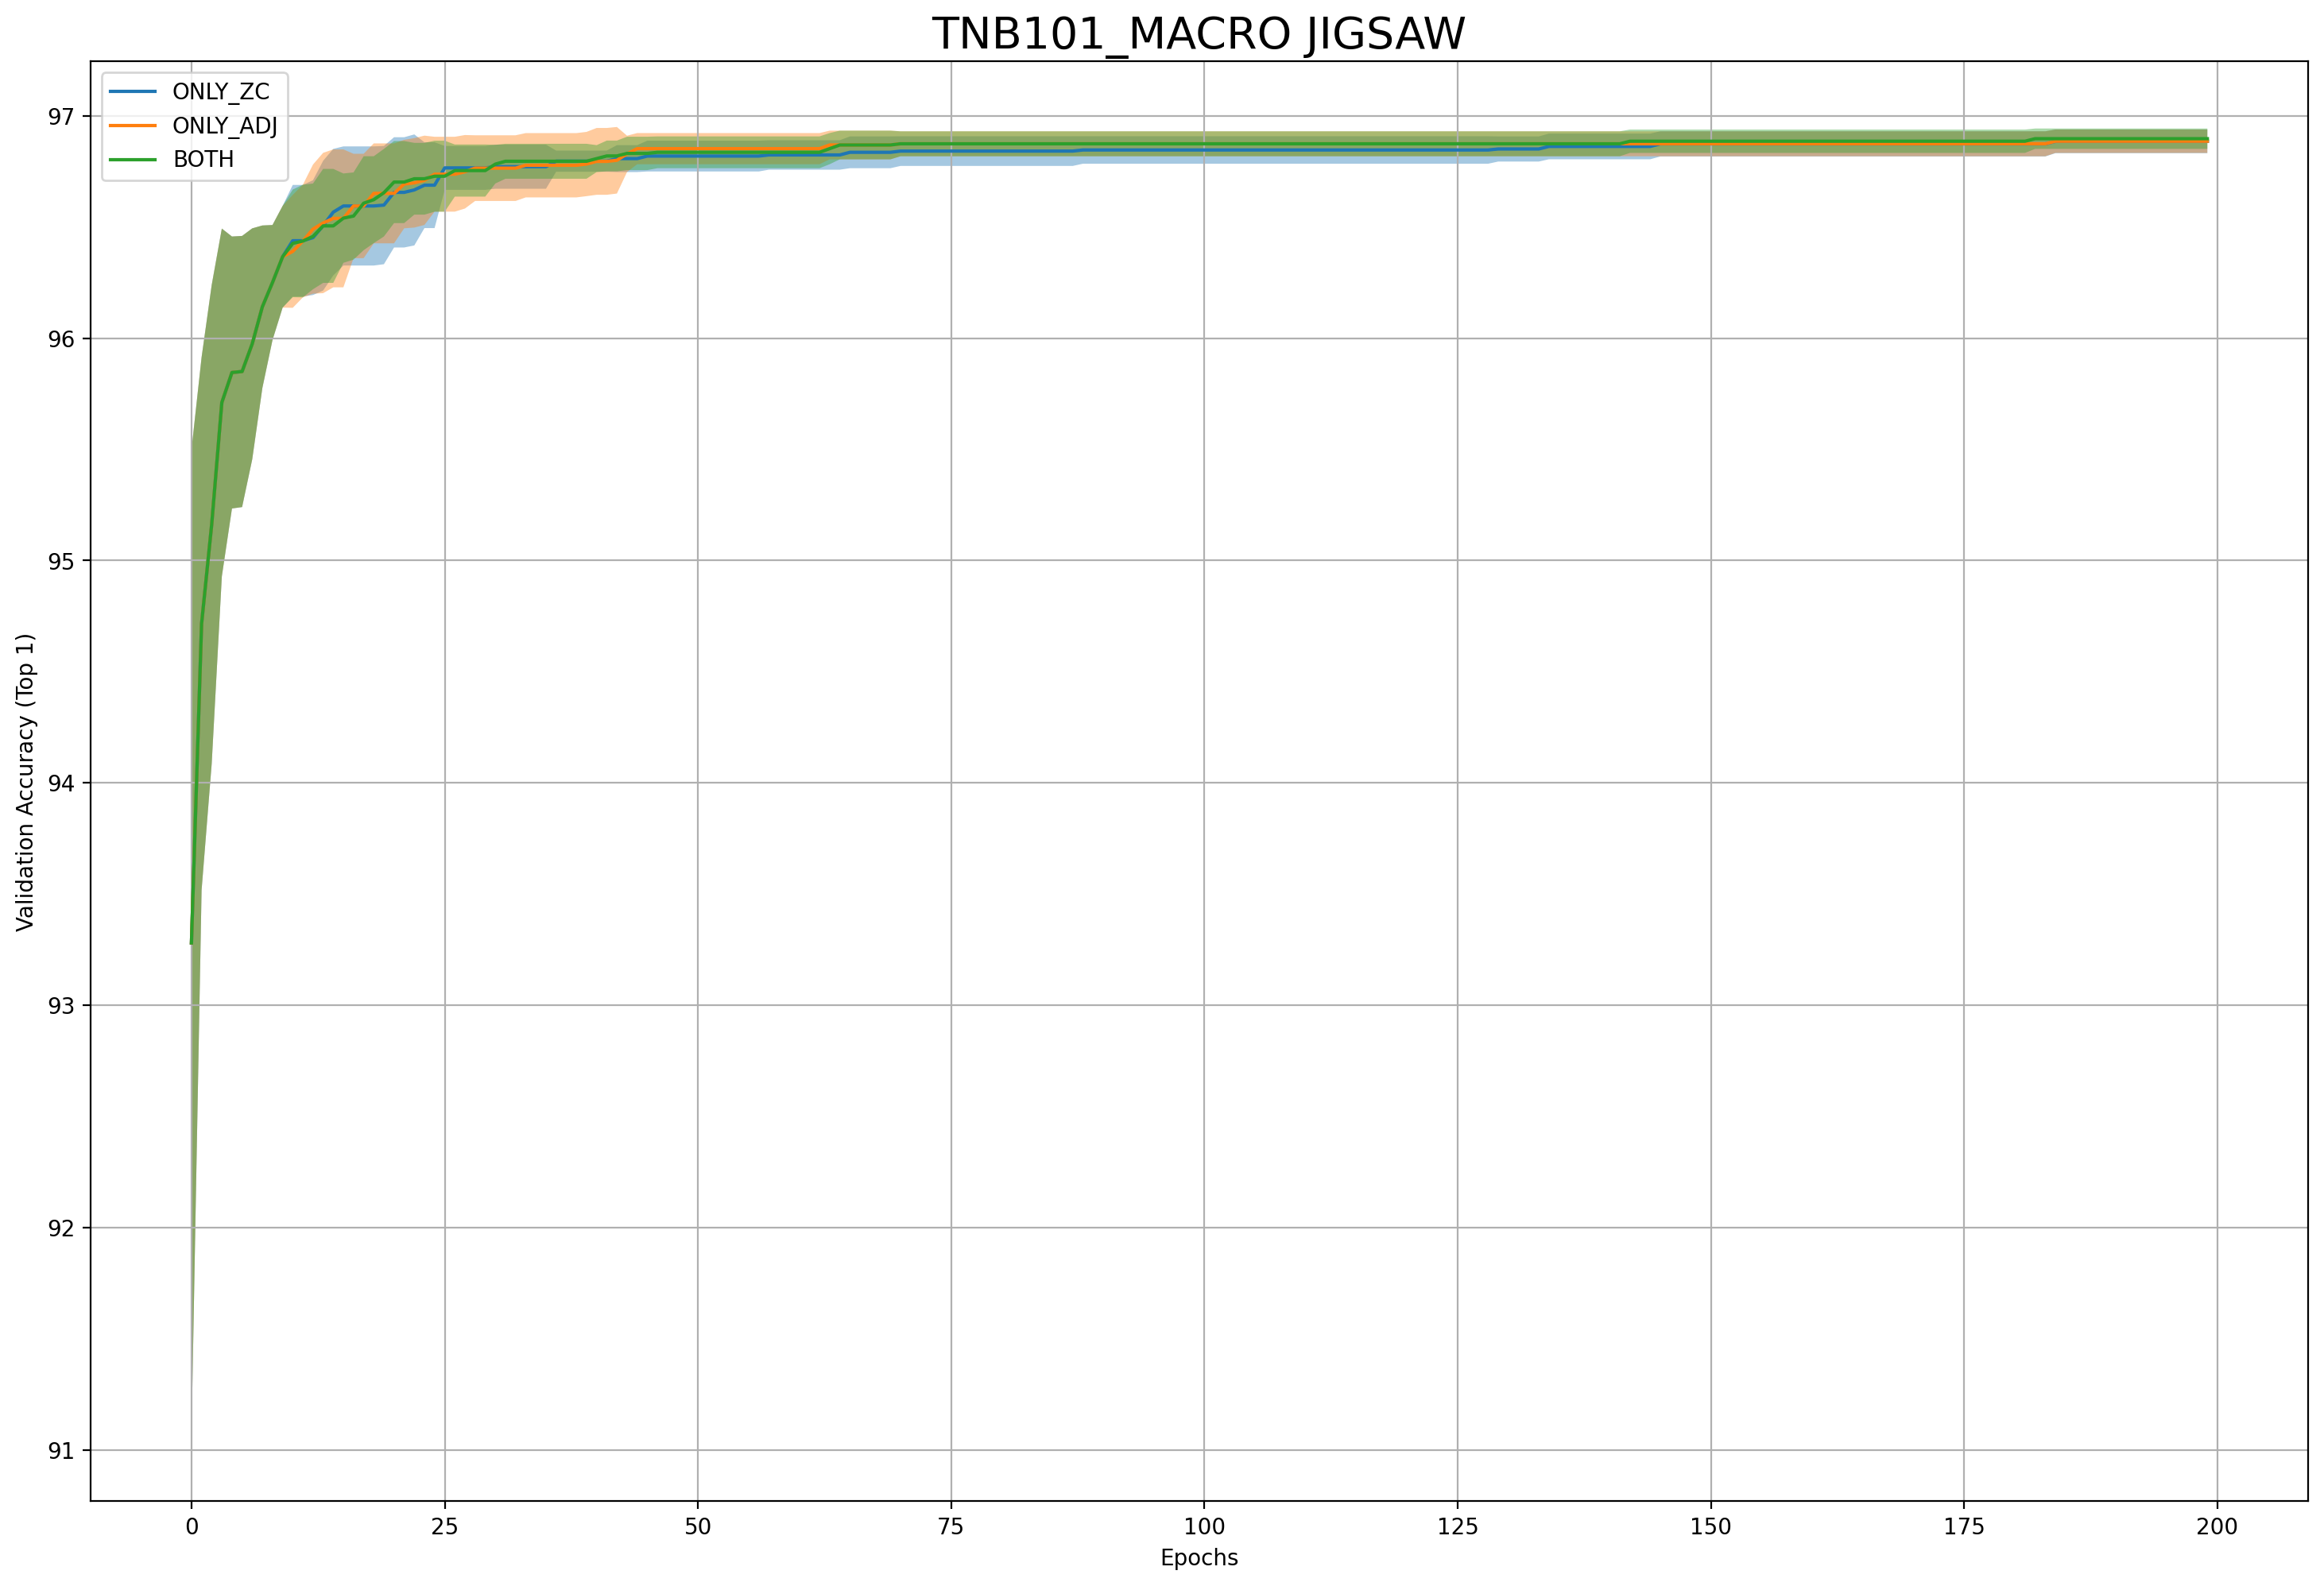

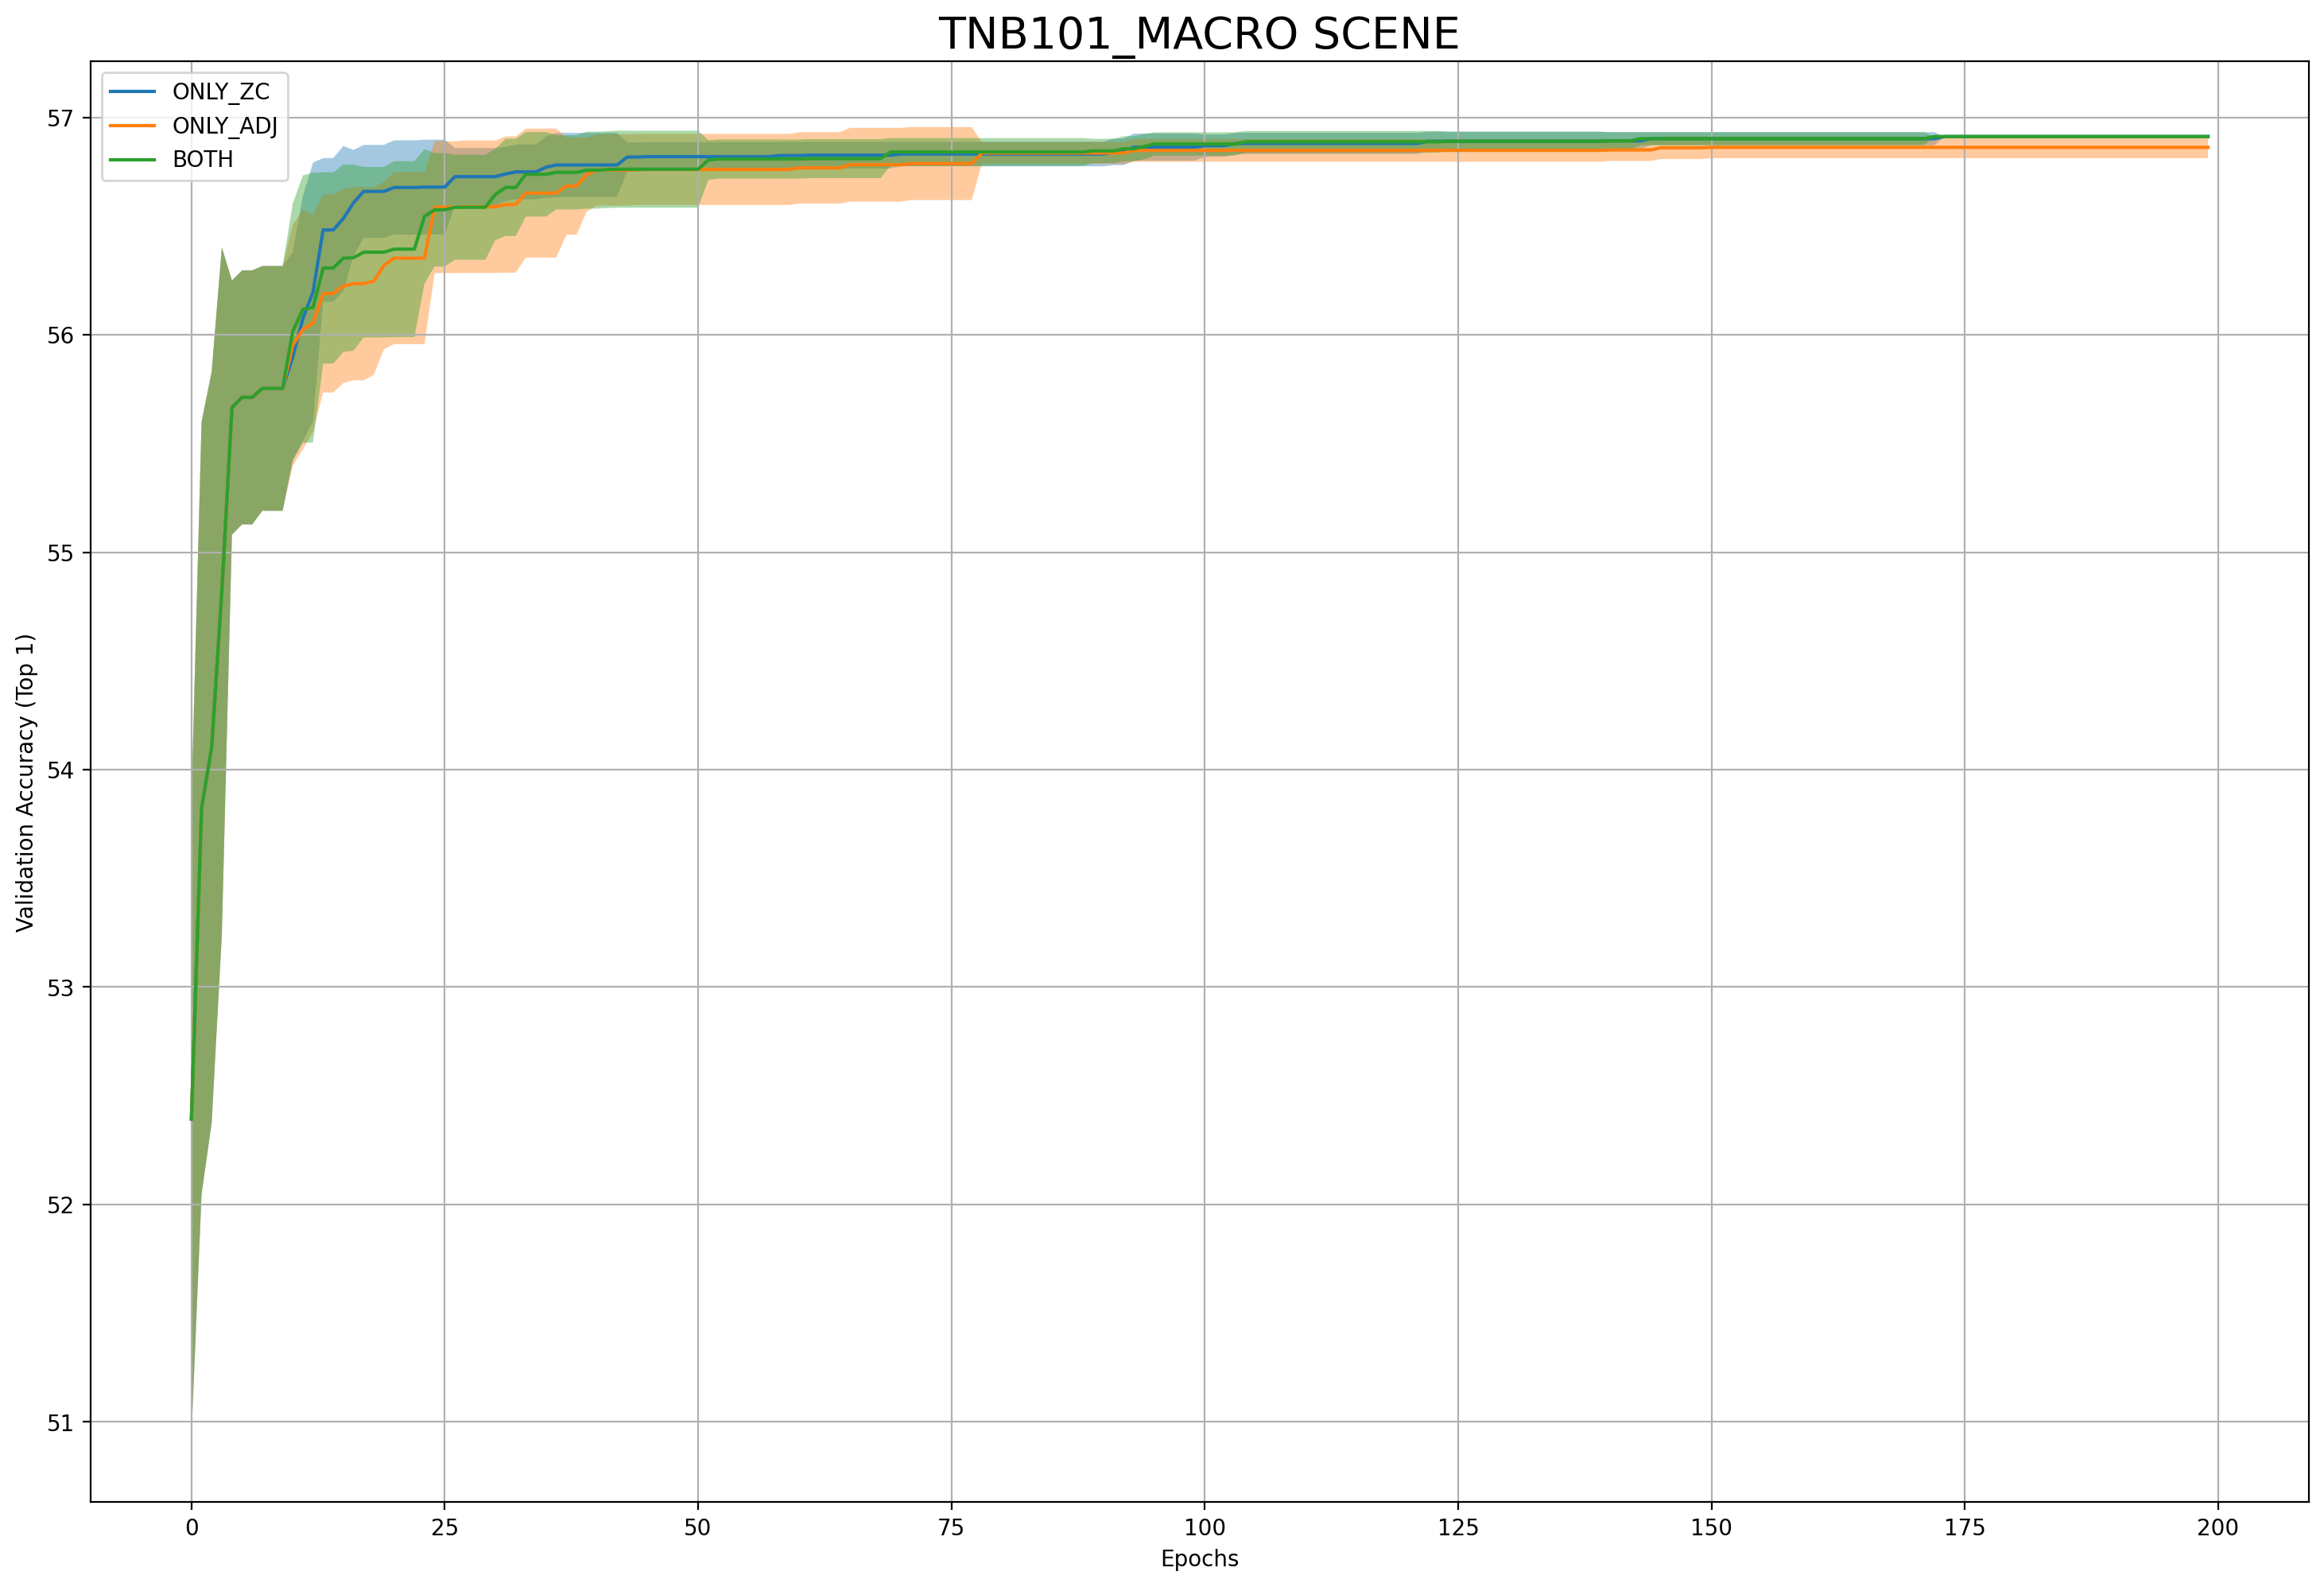

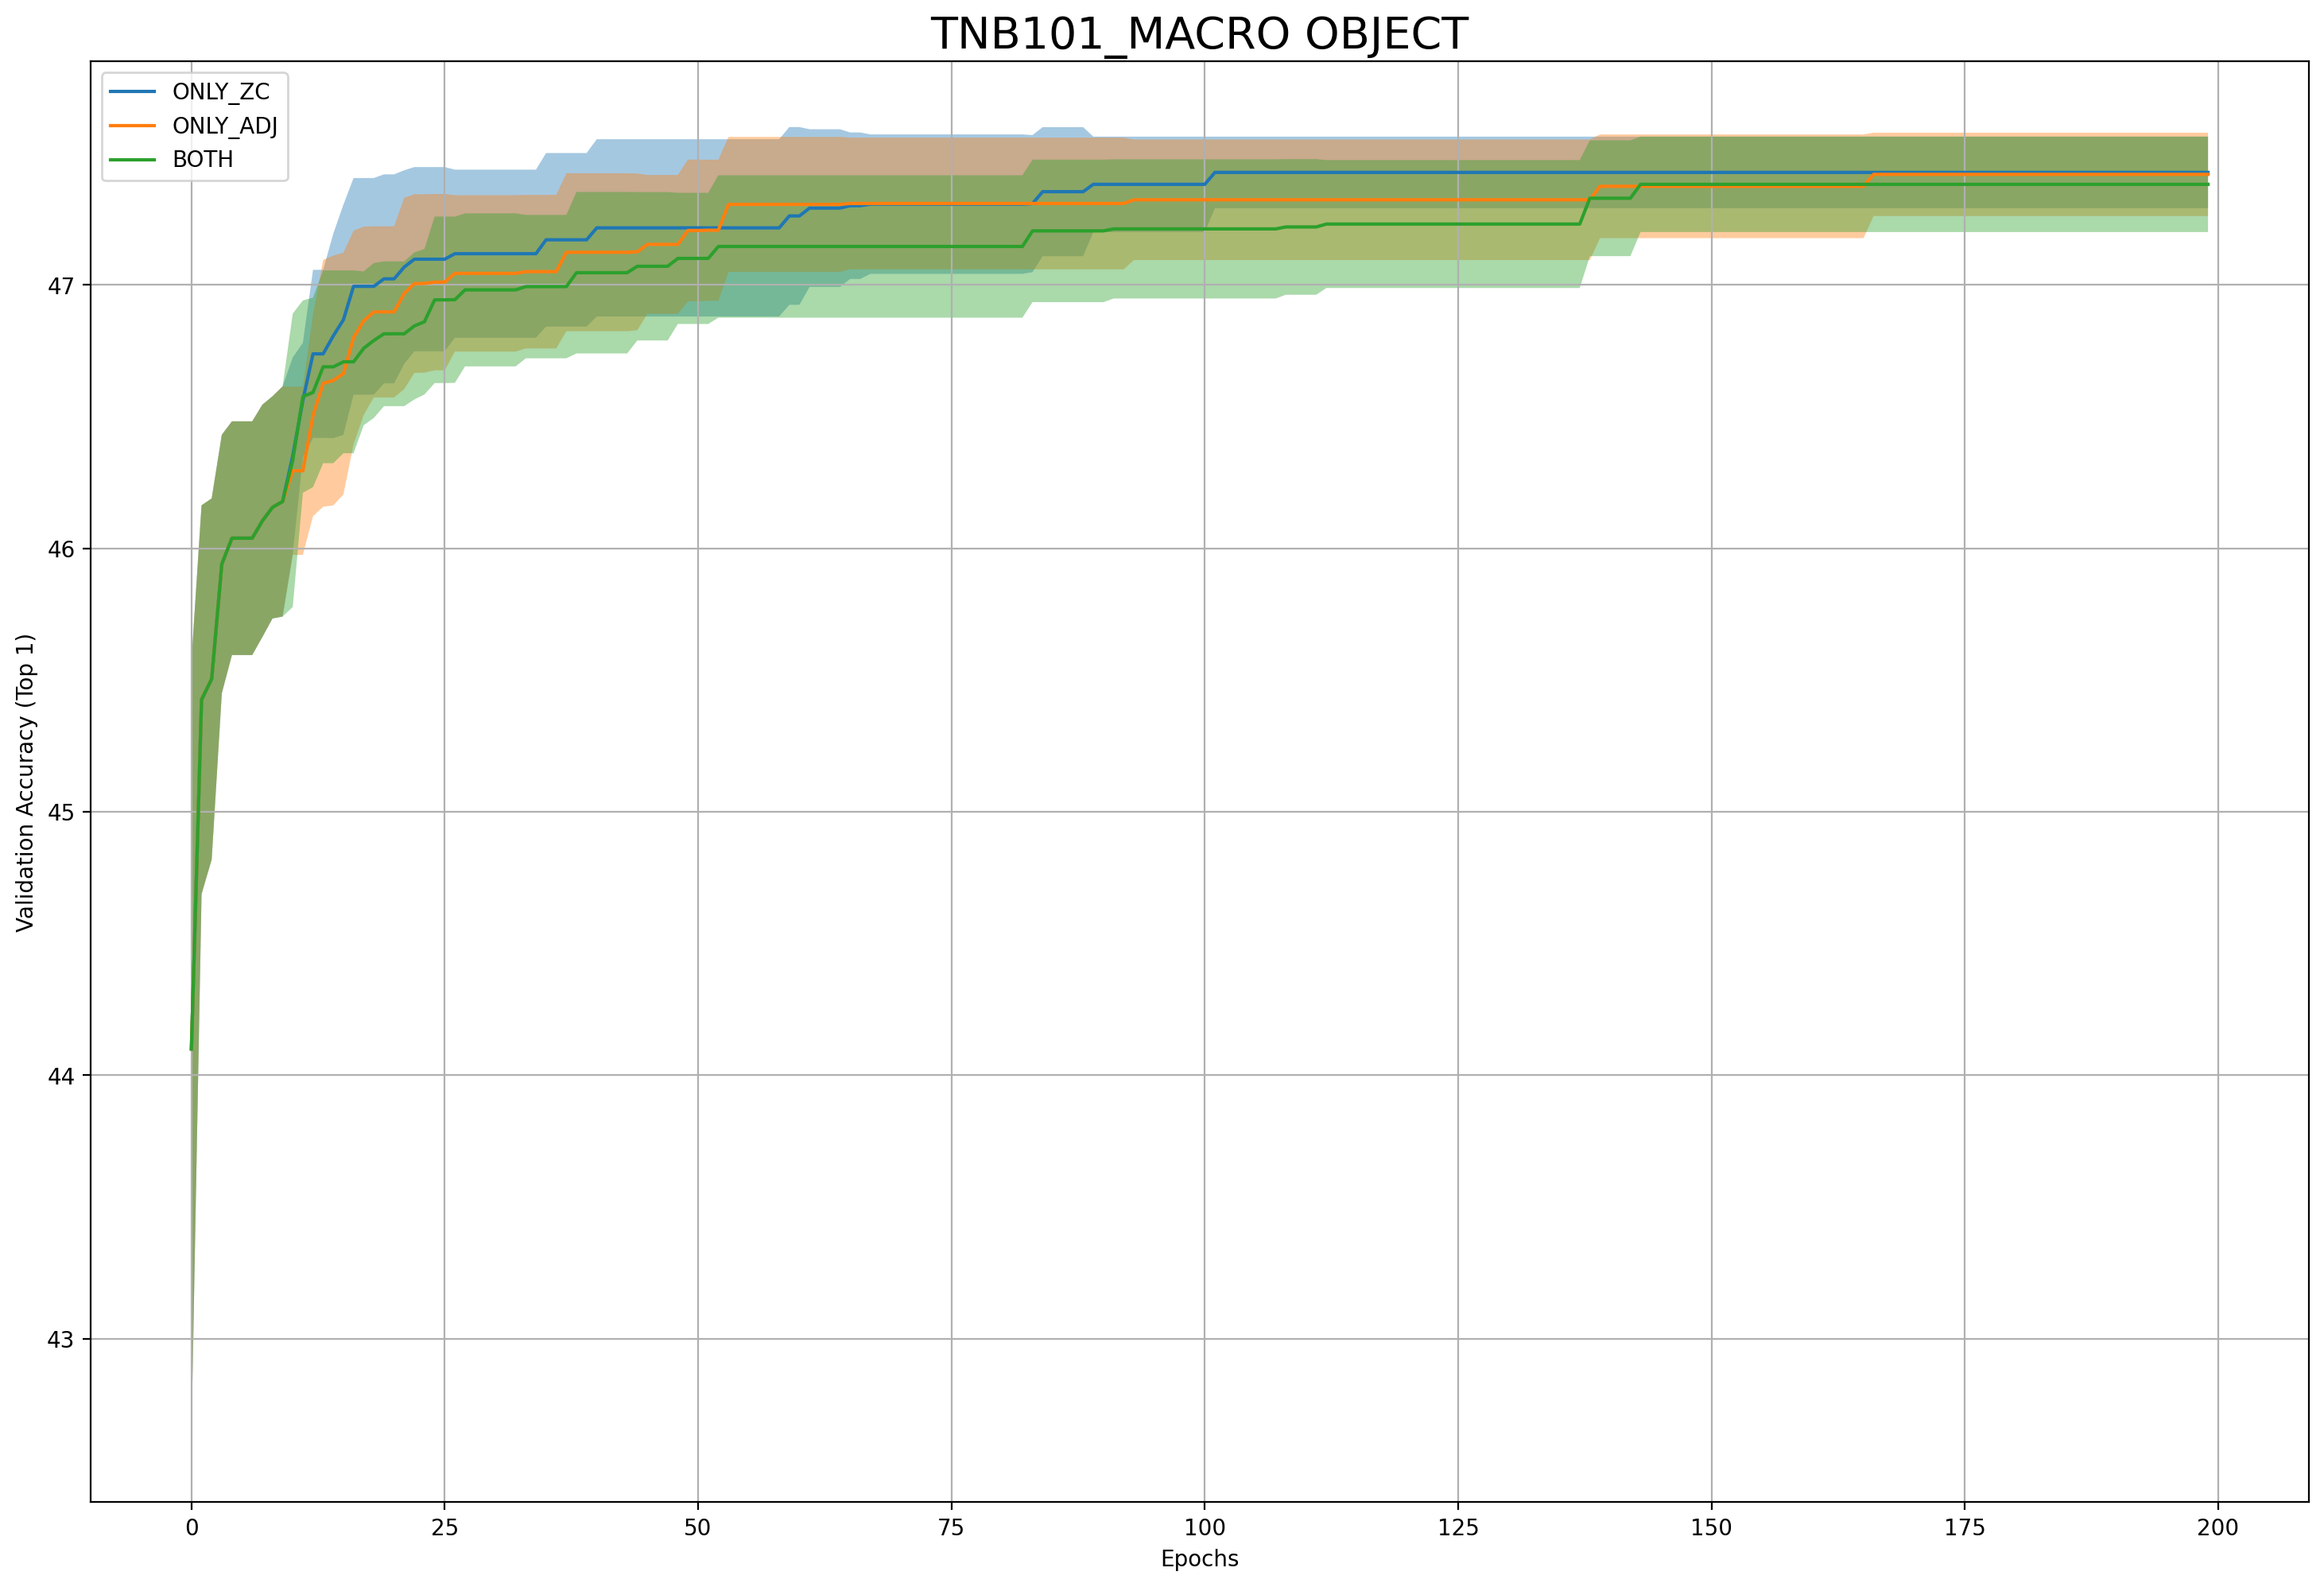

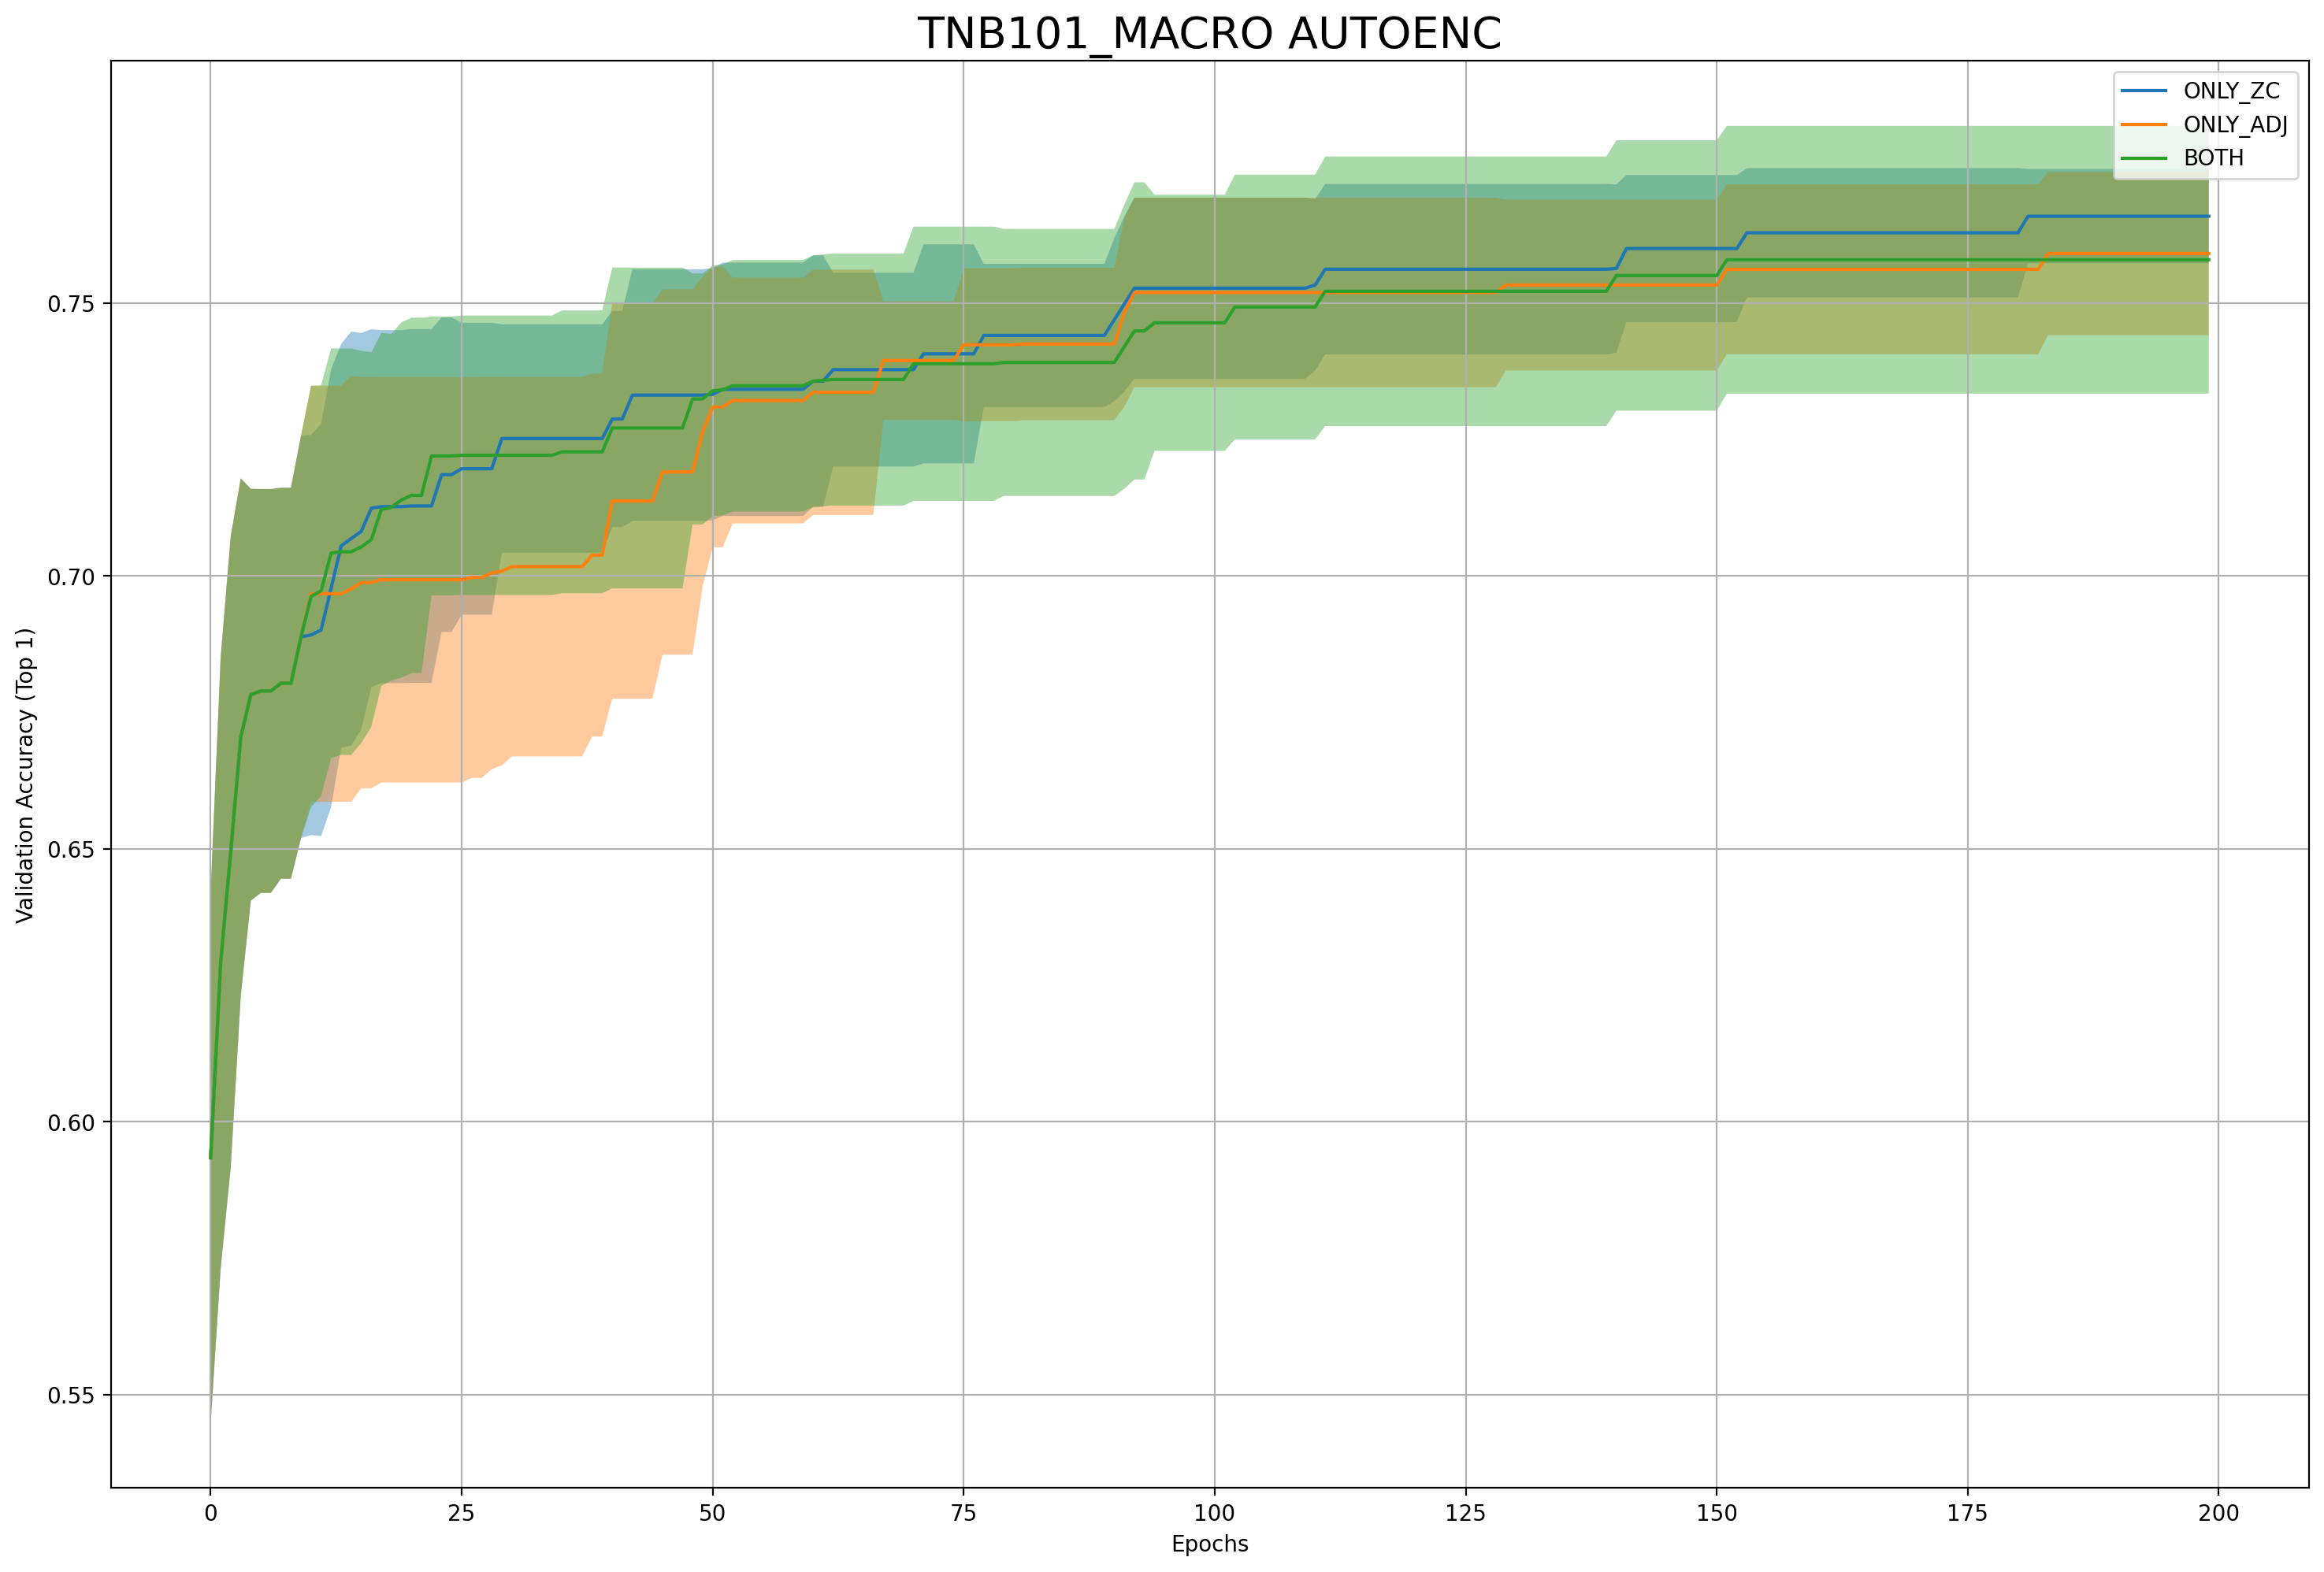

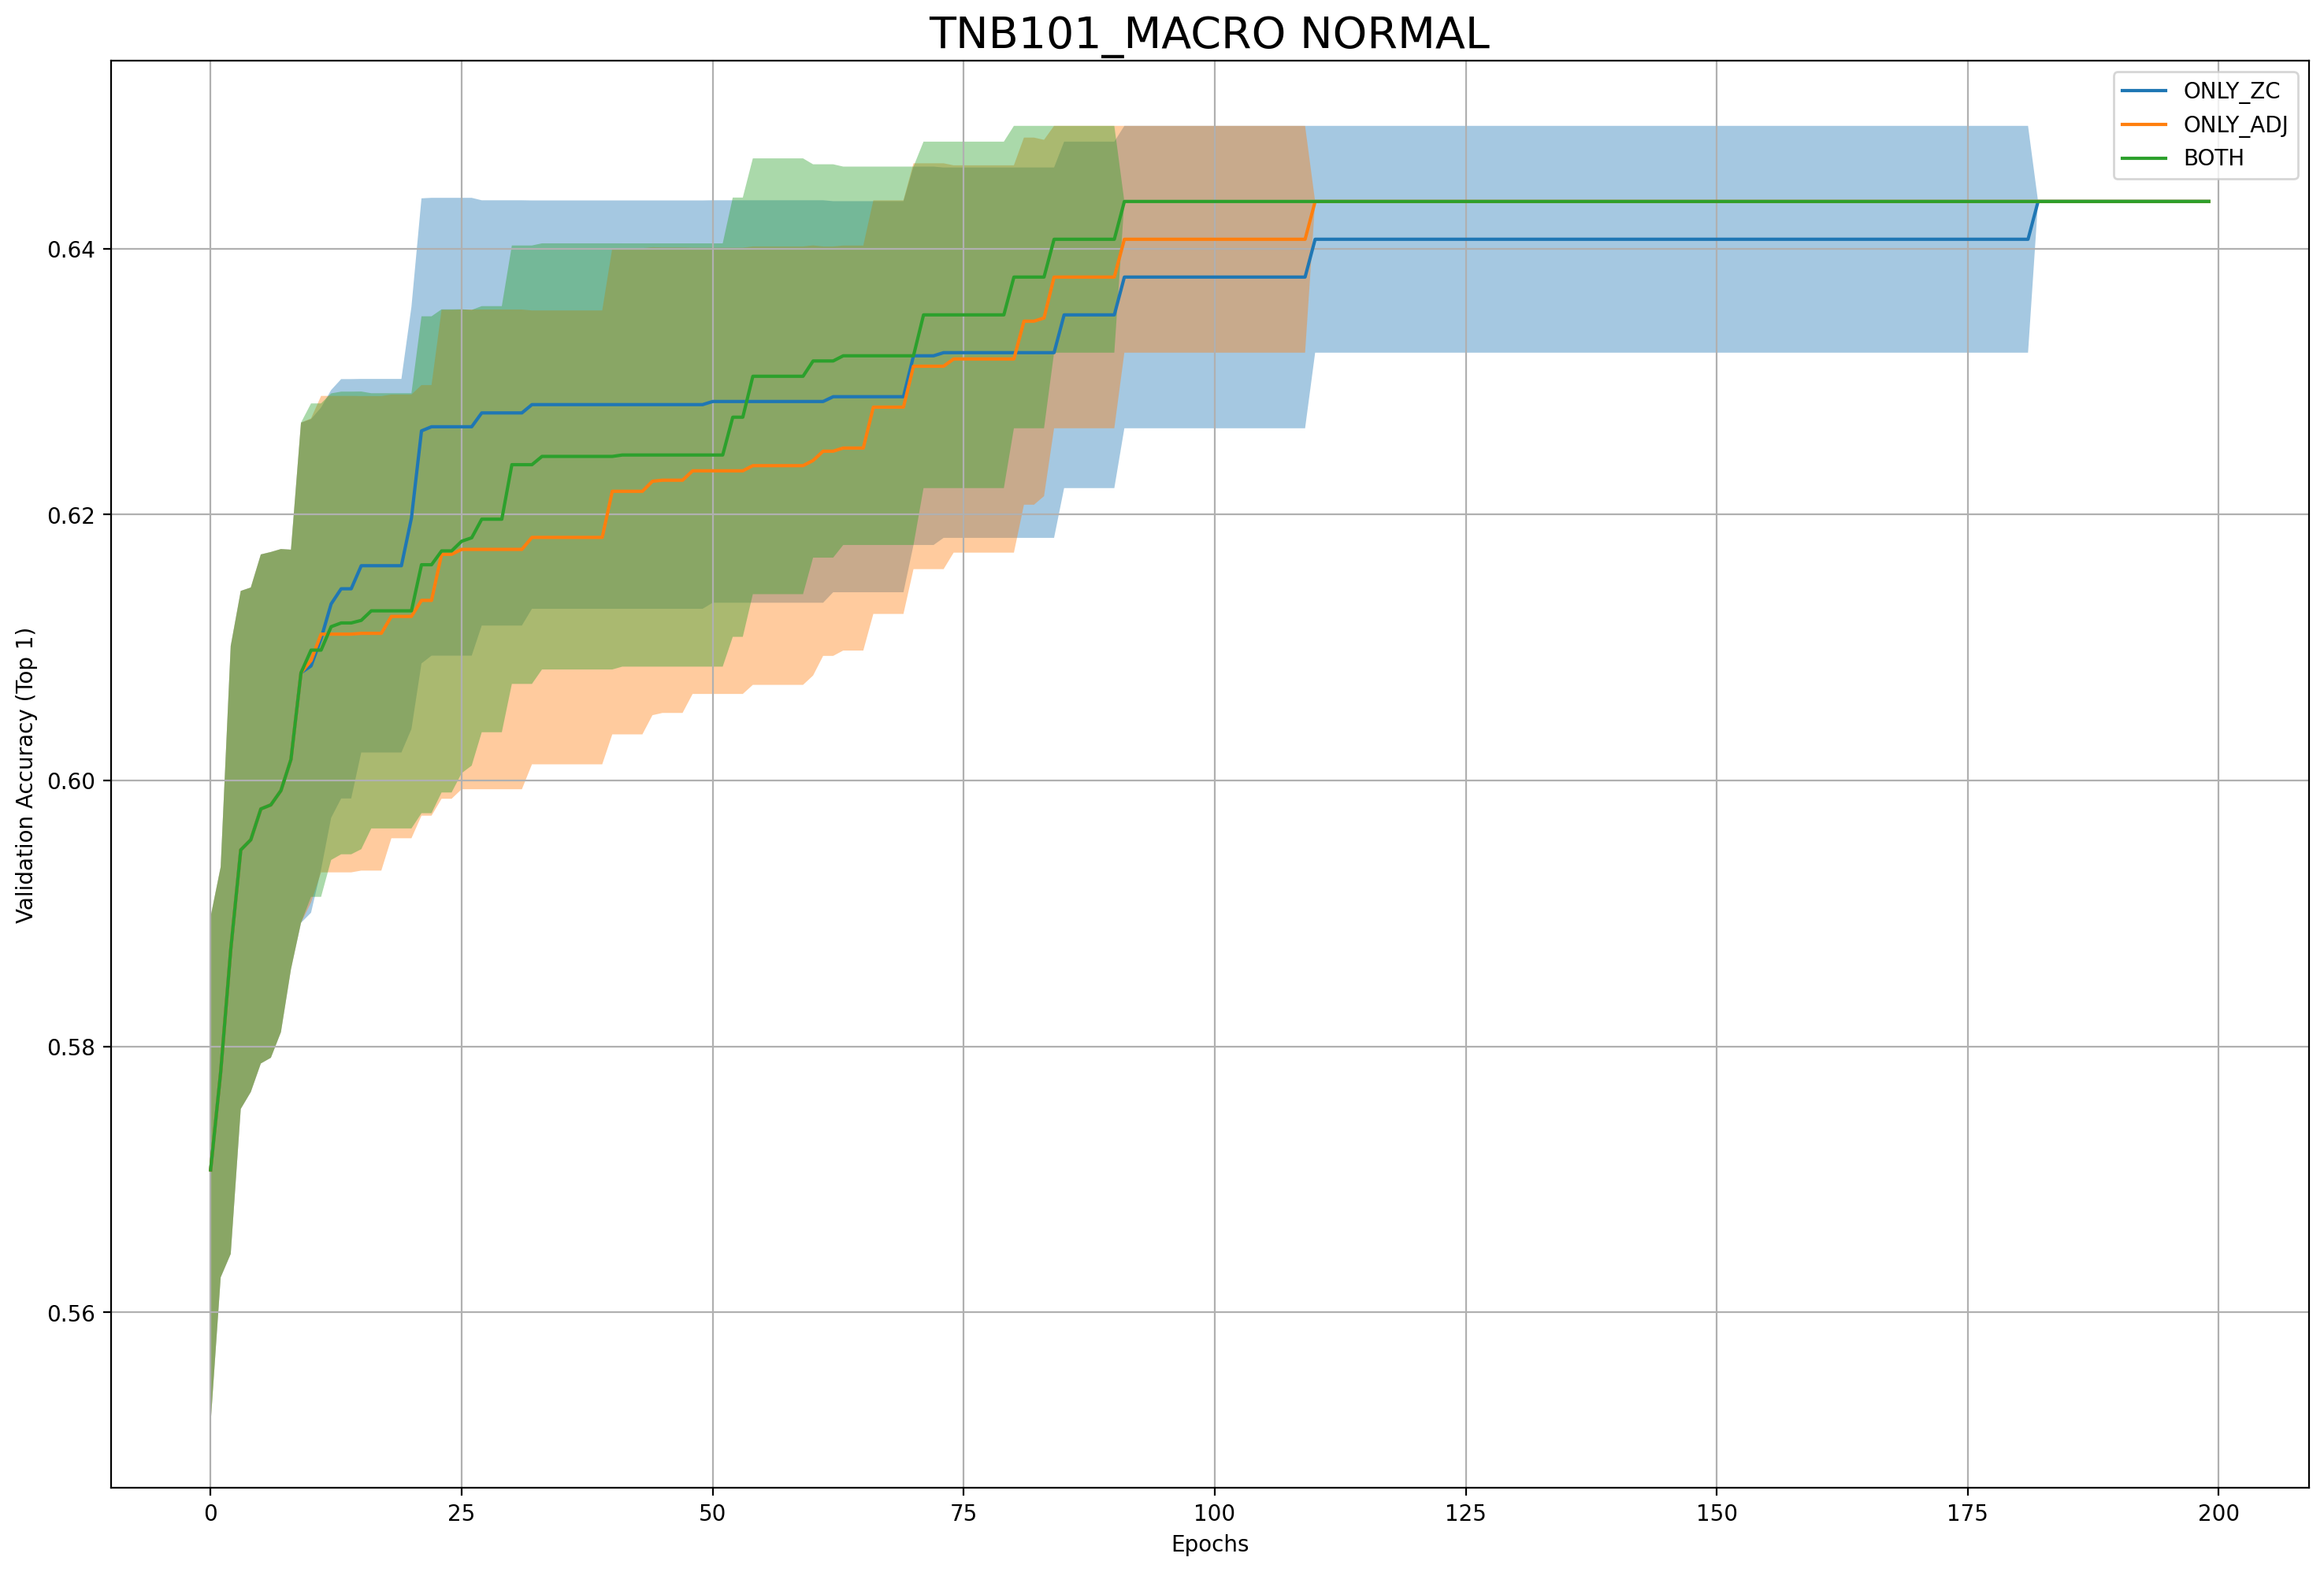

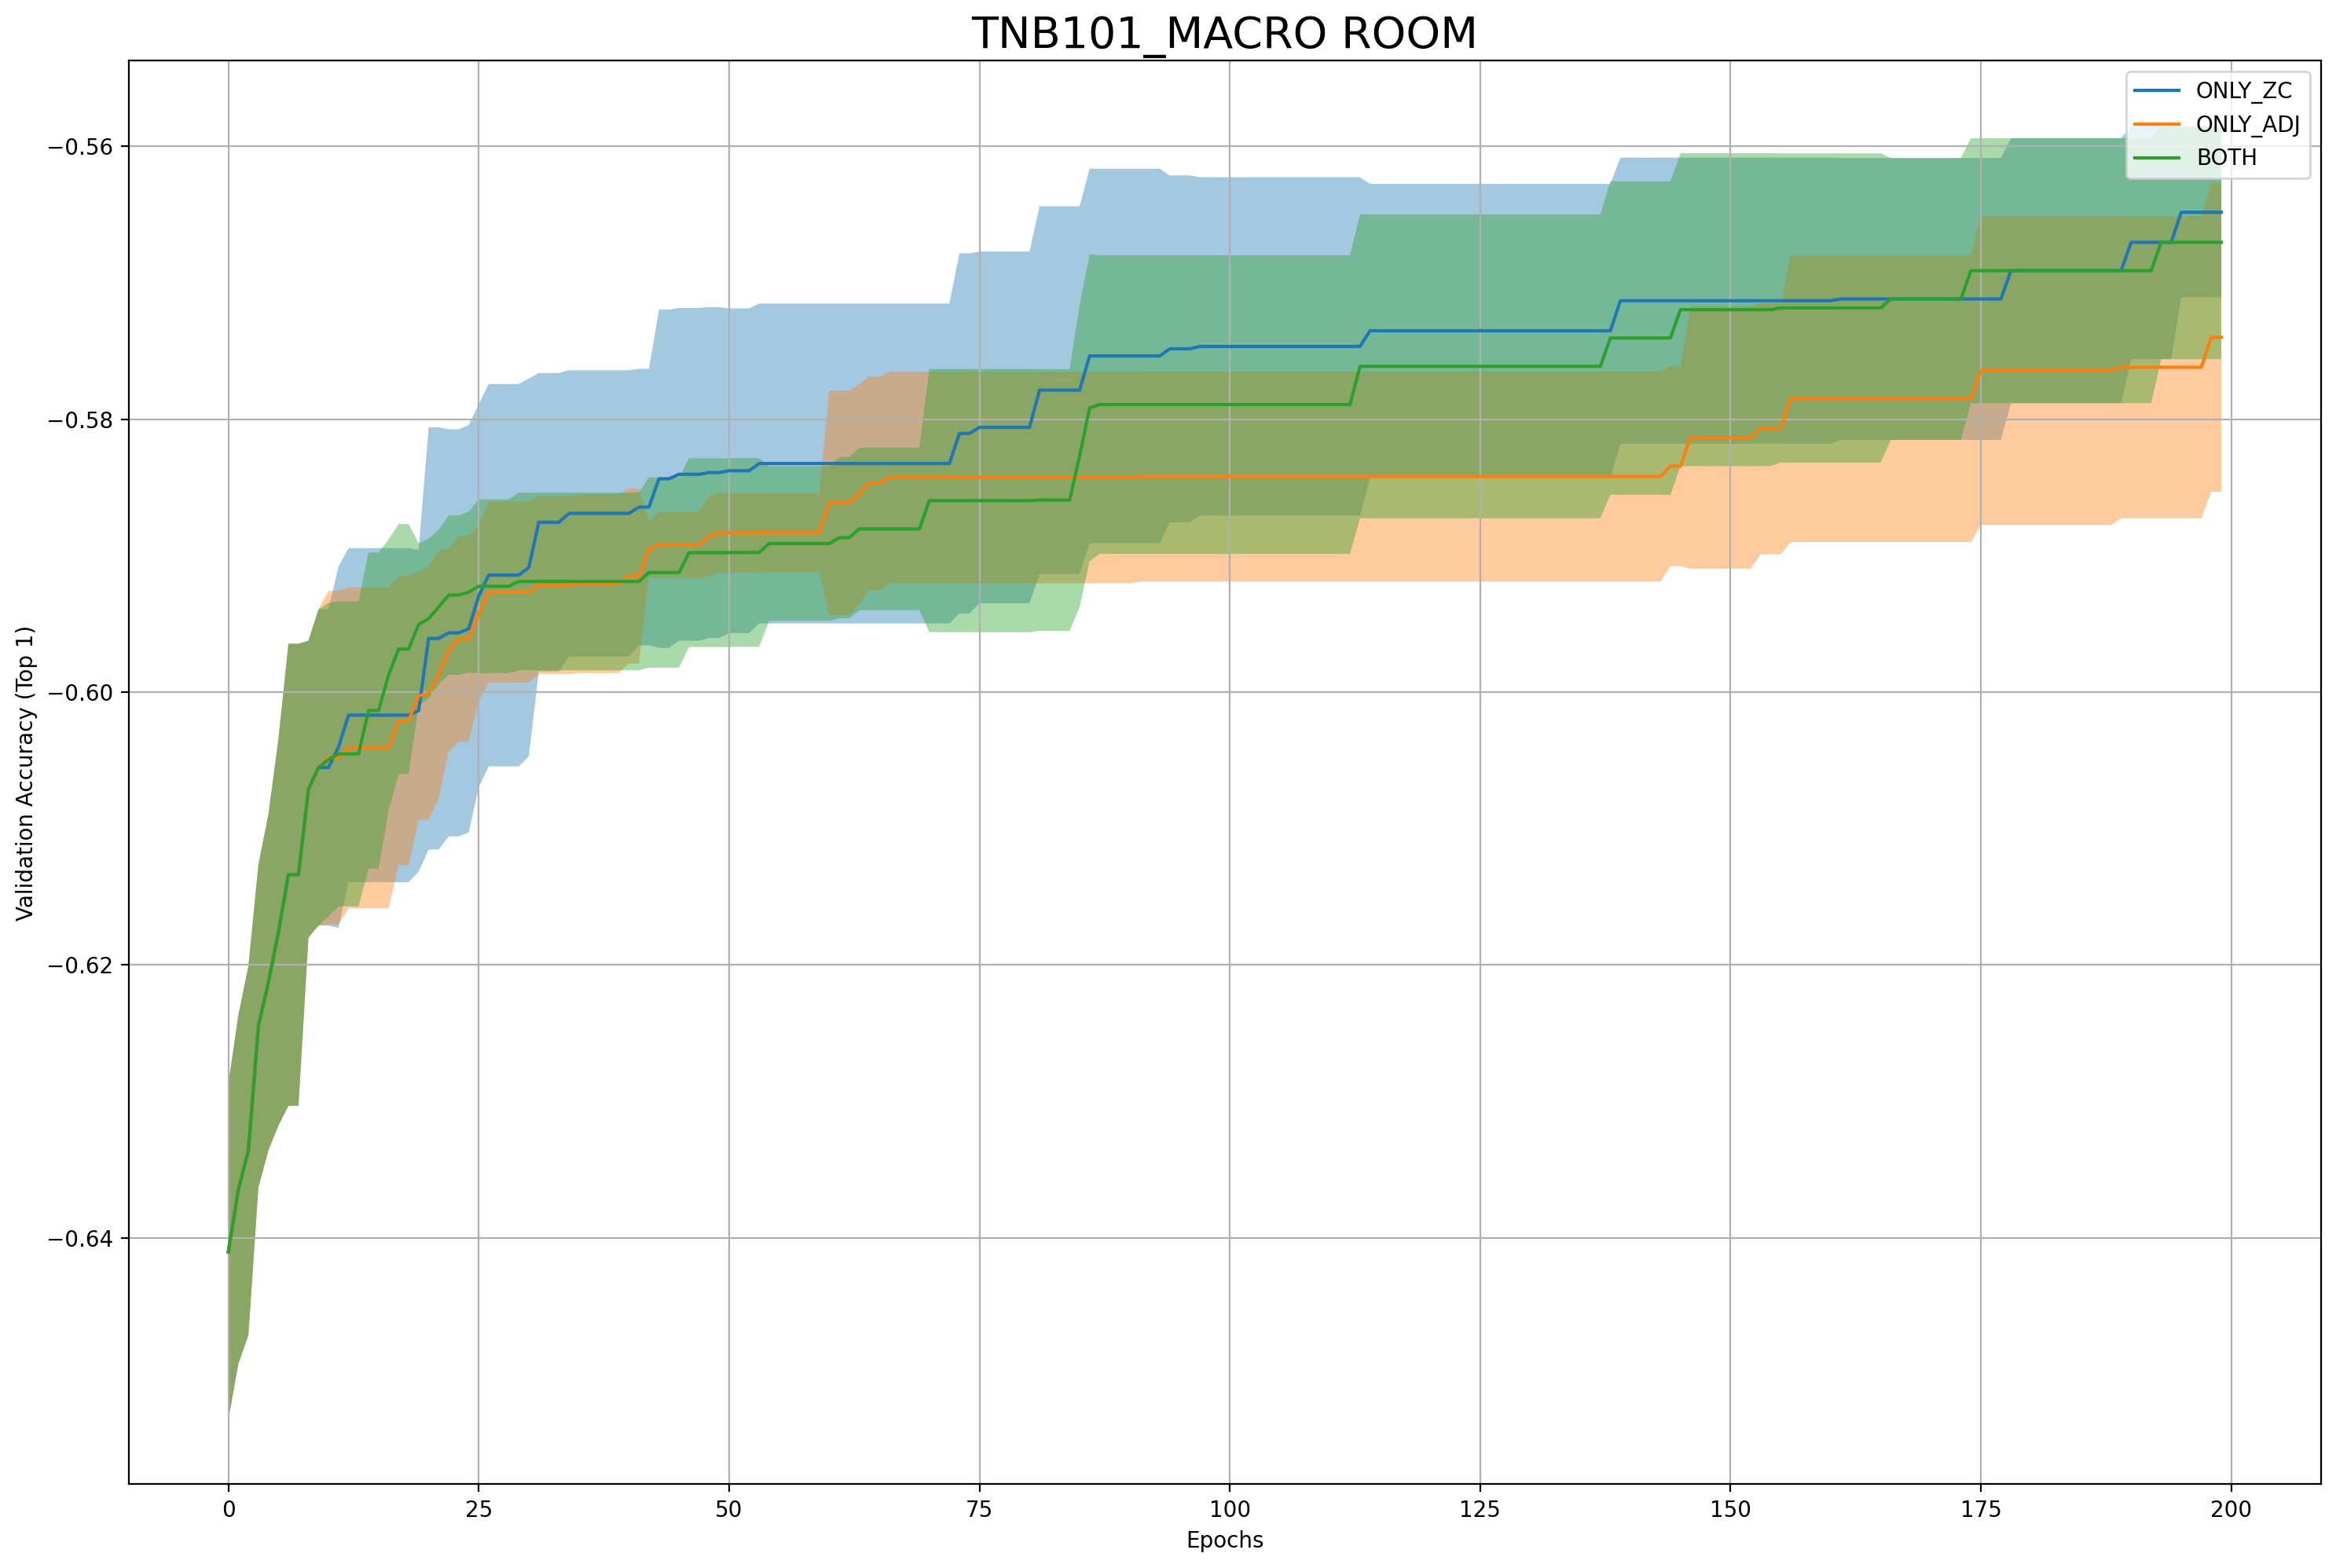

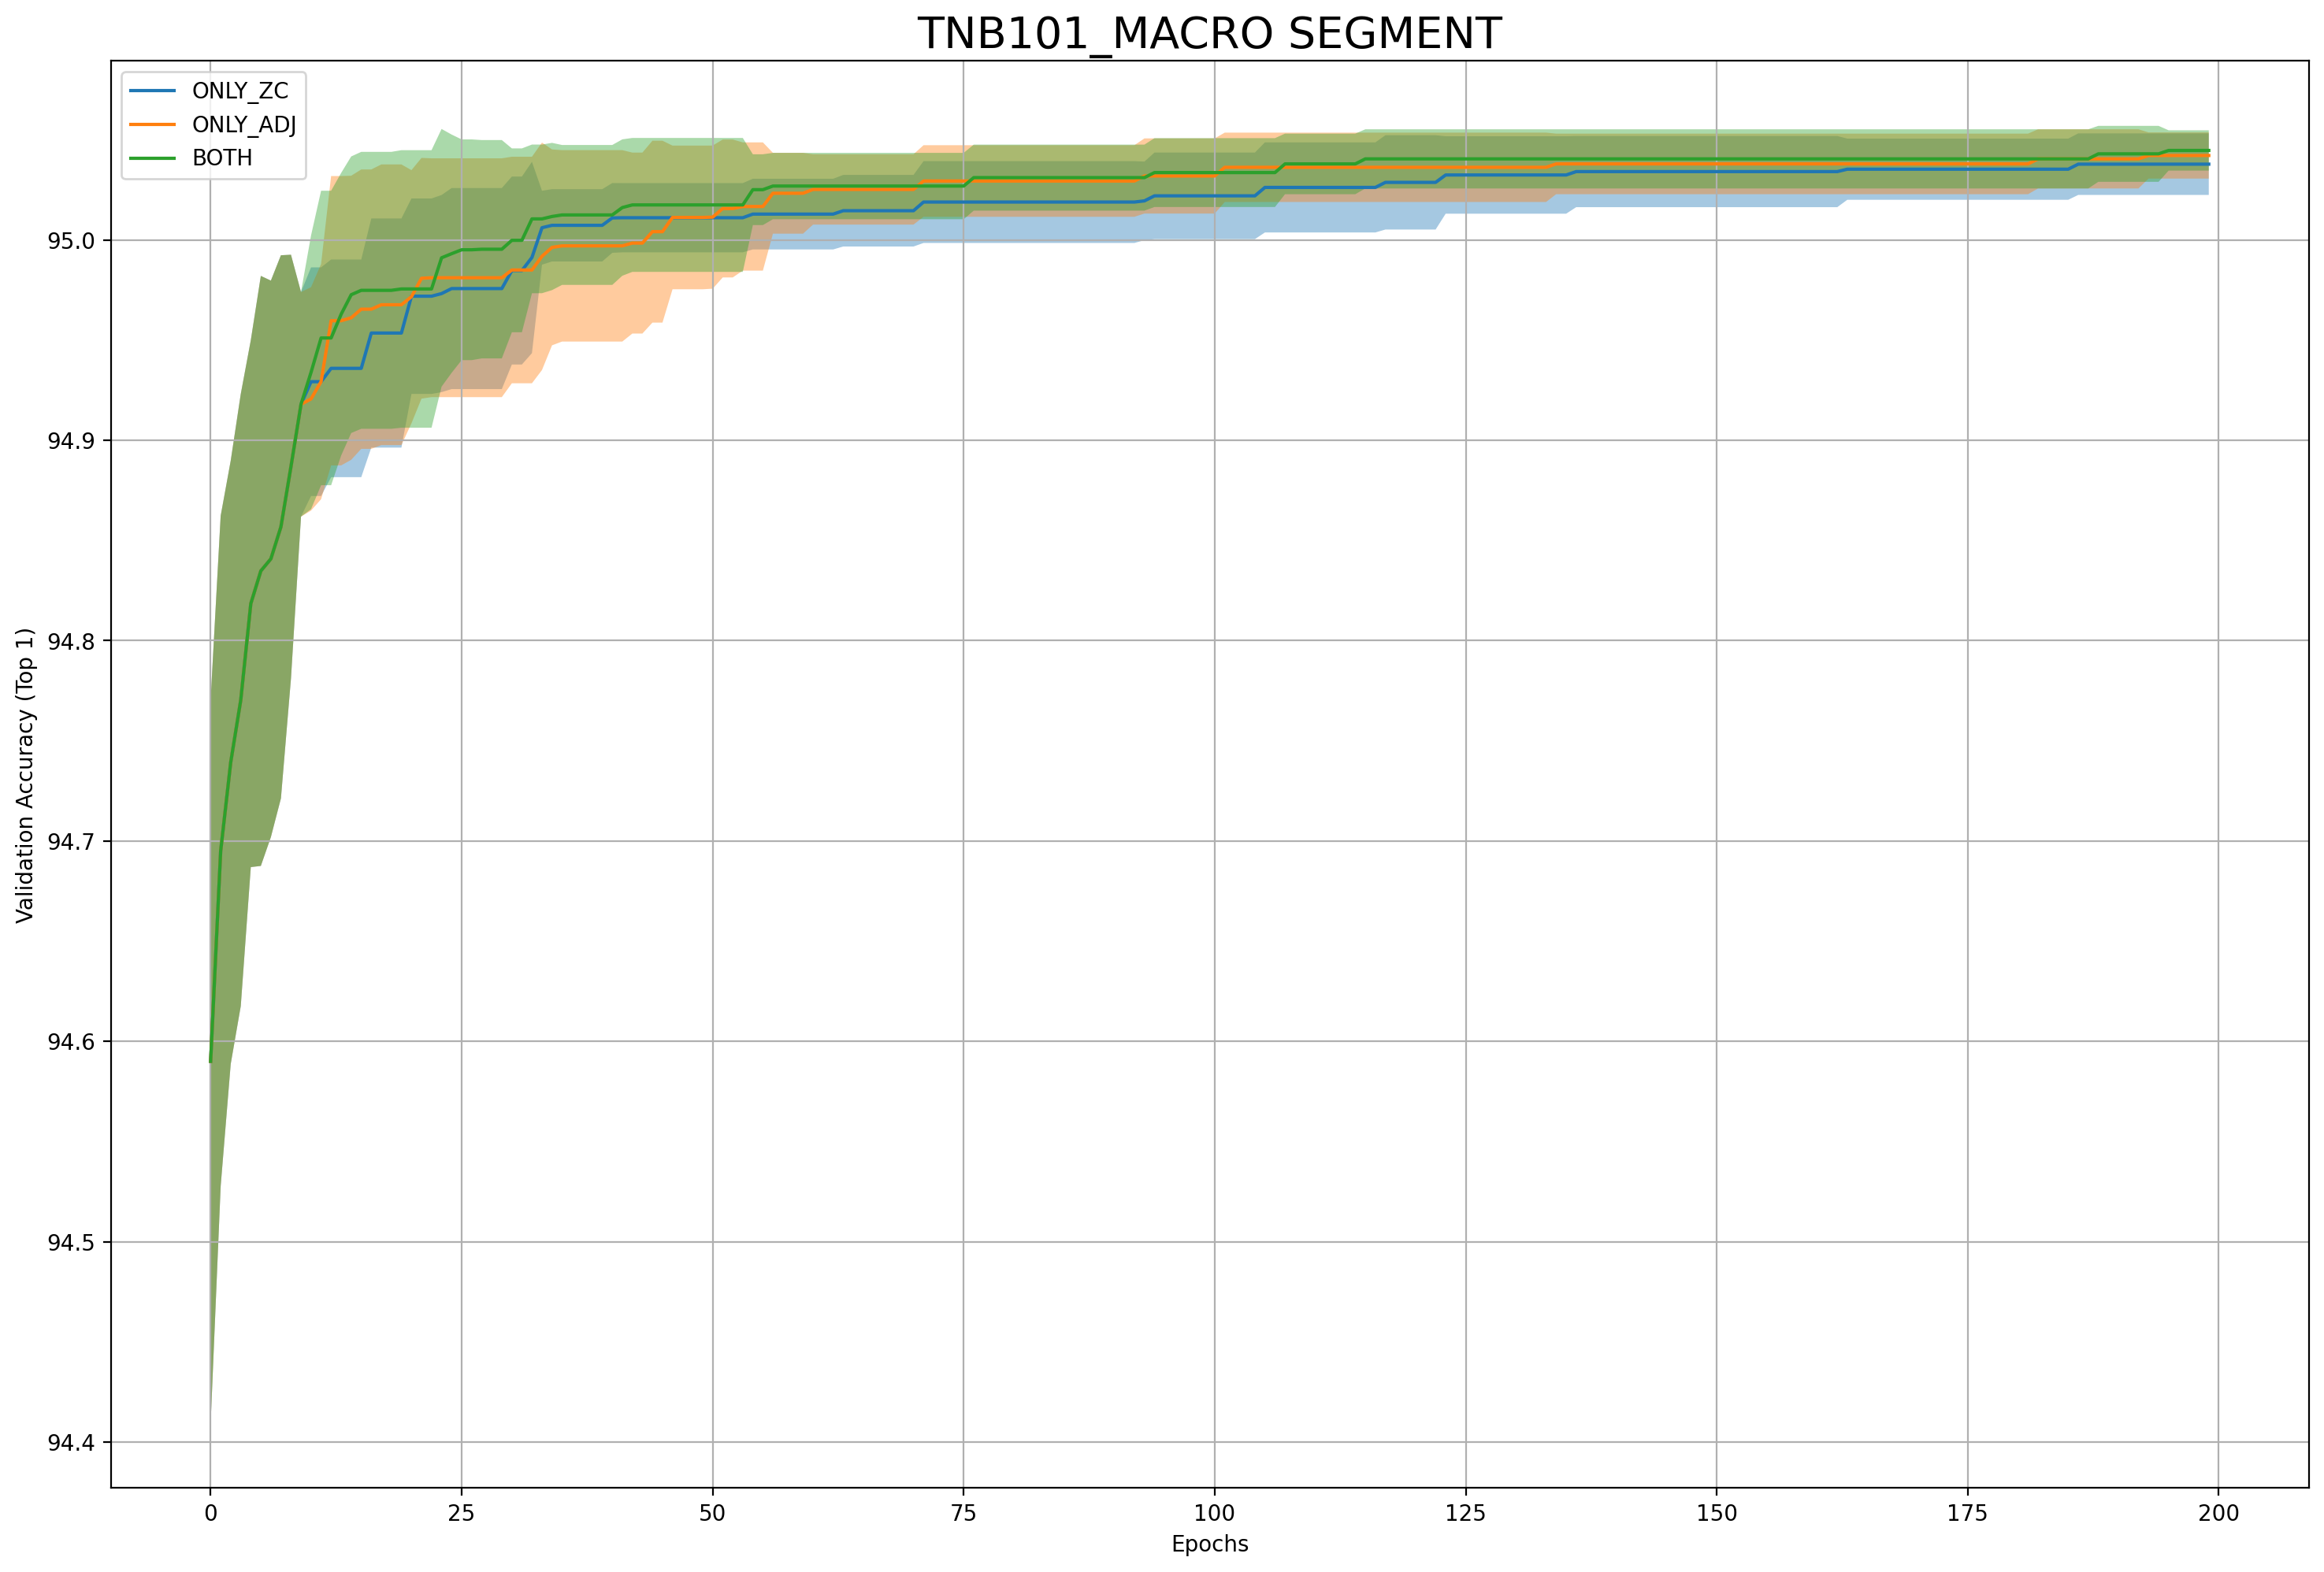

In [9]:
plot_search_space('nasbench201', only_zc_df, only_adj_df, zc_df)
plot_search_space('nasbench301', only_zc_df, only_adj_df, zc_df)
plot_search_space('transbench101_micro', only_zc_df, only_adj_df, zc_df)
plot_search_space('transbench101_macro', only_zc_df, only_adj_df, zc_df)